In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Чтобы графики были читаемыми
plt.rcParams["figure.figsize"] = (16, 9) #<- потом сие можно переопределить
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 10

## Определение функций $J(x, y)$ и их градиентов

In [3]:

alpha_aniso = 10.0  # для J1, сильно вытянутая квадратика

def J1(x: np.ndarray) -> float:
    """J1(x, y) = x^2 + alpha * y^2"""
    return float(x[0]**2 + alpha_aniso * x[1]**2)

def grad_J1(x: np.ndarray) -> np.ndarray:
    """∇J1 = (2x, 2 alpha y)"""
    return np.array([2 * x[0], 2 * alpha_aniso * x[1]], dtype=float)


def make_J2(a: float = 10.0, b: float = 1.0):
    """
    J2(x, y) = x^2 / a^2 + y^2 / b^2, вытянутый эллипс.
    """
    def J2(x: np.ndarray) -> float:
        return float(x[0]**2 / a**2 + x[1]**2 / b**2)

    def grad_J2(x: np.ndarray) -> np.ndarray:
        return np.array([2 * x[0] / a**2, 2 * x[1] / b**2], dtype=float)

    return J2, grad_J2

a_ell = 10.0
b_ell = 1.0
J2, grad_J2 = make_J2(a=a_ell, b=b_ell)


def J3(x: np.ndarray) -> float:
    """J3(x, y) = 70 (x-1)^2 + (y-1)^2 + 1"""
    return float(70 * (x[0] - 1)**2 + (x[1] - 1)**2 + 1)

def grad_J3(x: np.ndarray) -> np.ndarray:
    return np.array([140 * (x[0] - 1), 2 * (x[1] - 1)], dtype=float)


def J4(x: np.ndarray) -> float:
    """
    J4(x, y) = (x-8)^2 + (y-1)^2 + 70 (y + (x-8)^2 - 1)^2 + 1
    """
    u = x[0] - 8.0
    v = x[1] - 1.0
    w = v + u**2
    return float(u**2 + v**2 + 70 * w**2 + 1)

def grad_J4(x: np.ndarray) -> np.ndarray:
    u = x[0] - 8.0
    v = x[1] - 1.0
    w = v + u**2
    dJ_dx = 2 * u + 140 * w * (2 * u) / 2  # аккуратно: 2u + 140 w * 1 * (d w / d x) = 2u + 140 w * 2u
    dJ_dx = 2 * u + 280 * u * w
    dJ_dy = 2 * v + 140 * w
    return np.array([dJ_dx, dJ_dy], dtype=float)


def J5(x: np.ndarray) -> float:
    """
    J5(x, y) = (x-8)^2 + (y-1)^2 + 70 (x + y - 9)^2 + 1
    """
    u = x[0] - 8.0
    v = x[1] - 1.0
    w = x[0] + x[1] - 9.0
    return float(u**2 + v**2 + 70 * w**2 + 1)

def grad_J5(x: np.ndarray) -> np.ndarray:
    u = x[0] - 8.0
    v = x[1] - 1.0
    w = x[0] + x[1] - 9.0
    dJ_dx = 2 * u + 140 * w    # dw/dx = 1
    dJ_dy = 2 * v + 140 * w    # dw/dy = 1
    return np.array([dJ_dx, dJ_dy], dtype=float)

## Сами овраги

In [4]:
def ravine_descent(
    func,
    grad,
    v0,
    v1,
    step_gd: float = 0.01,      # шаг градиентного спуска
    h_ravine: float = 0.1,      # "овражный" шаг h
    max_iters: int = 20_000,
    tol_x: float = 1e-6,
    tol_f: float = 1e-6,
    stop_by_x: bool = True,
    stop_by_f: bool = True,
):
    """
    Овражный метод (ravine method) для функции func с градиентом grad.

    v0, v1 -- начальные точки, из которых делаются первые два градиентных шага.
    step_gd -- шаг градиентного спуска.
    h_ravine -- овражный шаг h в формуле для v_k.
    """
    v0 = np.asarray(v0, dtype=float)
    v1 = np.asarray(v1, dtype=float)

    xs = []
    fs = []

    # Первый градиентный шаг: v0 -> x0
    x0 = v0 - step_gd * grad(v0)
    f0 = func(x0)
    xs.append(x0.copy())
    fs.append(f0)

    # Второй градиентный шаг: v1 -> x1
    x1 = v1 - step_gd * grad(v1)
    f1 = func(x1)
    xs.append(x1.copy())
    fs.append(f1)

    stop_reason = None

    for k in range(1, max_iters):
        x_k = xs[-1]
        x_prev = xs[-2]
        f_k = fs[-1]
        f_prev = fs[-2]

        dx = x_k - x_prev
        norm_dx = np.linalg.norm(dx)

        if norm_dx < 1e-12:
            stop_reason = f"direction degenerate: ||x_k - x_(k-1)|| = {norm_dx:.2e}"
            break

        direction = dx / norm_dx
        sign_J = np.sign(f_k - f_prev)

        # если J_k == J_{k-1}, овражный шаг бессмысленен, можно не смещаться
        if sign_J == 0:
            v_k = x_k.copy()
        else:
            v_k = x_k - direction * h_ravine * sign_J

        # шаг градиентного метода из v_k
        x_next = v_k - step_gd * grad(v_k)
        f_next = func(x_next)

        xs.append(x_next.copy())
        fs.append(f_next)

        dx_norm = np.linalg.norm(x_next - x_k)
        df_abs = abs(f_next - f_k)

        if stop_by_x and dx_norm < tol_x:
            stop_reason = f"tol_x: ||x_(k+1)-x_k|| = {dx_norm:.2e}"
            break
        if stop_by_f and df_abs < tol_f:
            stop_reason = f"tol_f: |J_(k+1)-J_k| = {df_abs:.2e}"
            break

    if stop_reason is None:
        stop_reason = f"max_iters = {max_iters}"

    return {
        "x_path": np.array(xs),
        "f_path": np.array(fs),
        "iters": len(xs),
        "stop_reason": stop_reason,
    }

In [5]:
FUNCTIONS_RAVINE = {
    "j1": {
        "func": J1,
        "grad": grad_J1,
        "title": rf"$J_1(x, y) = x^2 + {alpha_aniso} y^2$",
        "v0": np.array([5.0, 5.0]),
        "v1": np.array([4.0, 5.0]),
        "step_gd": 0.05,
        "h_ravine": 0.5,
    },
    "j2": {
        "func": J2,
        "grad": grad_J2,
        "title": rf"$J_2(x, y) = \frac{{x^2}}{{{a_ell}^2}} + \frac{{y^2}}{{{b_ell}^2}}$",
        "v0": np.array([5.0, 3.0]),
        "v1": np.array([5.0, 4.0]),
        "step_gd": 0.05,
        "h_ravine": 0.5,
    },
    "j3": {
        "func": J3,
        "grad": grad_J3,
        "title": r"$J_3(x, y) = 70(x-1)^2 + (y-1)^2 + 1$",
        "v0": np.array([-5.0, 5.0]),
        "v1": np.array([-4.0, 5.0]),
        "step_gd": 0.01,
        "h_ravine": 0.2,
    },
    "j4": {
        "func": J4,
        "grad": grad_J4,
        "title": r"$J_4(x, y) = (x-8)^2 + (y-1)^2 + 70(y+(x-8)^2-1)^2 + 1$",
        "v0": np.array([8.0, 3.0]),
        "v1": np.array([7.0, 3.0]),
        "step_gd": 0.001,
        "h_ravine": 0.1,
    },
    "j5": {
        "func": J5,
        "grad": grad_J5,
        "title": r"$J_5(x, y) = (x-8)^2 + (y-1)^2 + 70(x+y-9)^2 + 1$",
        "v0": np.array([8.0, 3.0]),
        "v1": np.array([9.0, 2.0]),
        "step_gd": 0.005,
        "h_ravine": 0.1,
    },
}

## Строилка графиков

In [6]:


def plot_trajectory(xs: np.ndarray, title: str, filename: str):
    """
    График траектории x_k = (x_k, y_k) на плоскости.
    """
    plt.figure()
    plt.plot(xs[:, 0], xs[:, 1], marker="o", linestyle="-")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename, dpi=200)
    plt.close()


def plot_J_values(fs: np.ndarray, title: str, filename: str):
    """
    График J(x_k) по итерациям.
    """
    k = np.arange(len(fs))
    plt.figure()
    plt.plot(k, fs, marker="o", linestyle="-")
    plt.xlabel("итерация k")
    plt.ylabel("J(x_k)")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename, dpi=200)
    plt.close()

In [7]:
results_ravine = {}

for key, cfg in FUNCTIONS_RAVINE.items():
    func = cfg["func"]
    grad = cfg["grad"]
    v0 = cfg["v0"]
    v1 = cfg["v1"]
    step_gd = cfg["step_gd"]
    h_ravine = cfg["h_ravine"]

    res = ravine_descent(
        func=func,
        grad=grad,
        v0=v0,
        v1=v1,
        step_gd=step_gd,
        h_ravine=h_ravine,
        max_iters=20_000,
        tol_x=1e-6,
        tol_f=1e-6,
        stop_by_x=True,
        stop_by_f=True,
    )

    xs = res["x_path"]
    fs = res["f_path"]

    traj_filename = f"{key}_traj_ravine.png"
    J_filename = f"{key}_J_ravine.png"

    plot_trajectory(
        xs,
        title=f"Траектория овражного метода для {cfg['title']}",
        filename=traj_filename,
    )
    plot_J_values(
        fs,
        title=f"Убывание J(x_k) для {cfg['title']} (овражный метод)",
        filename=J_filename,
    )

    results_ravine[key] = {
        "traj_file": traj_filename,
        "J_file": J_filename,
        "x_star": xs[-1],
        "J_star": fs[-1],
        "iters": res["iters"],
        "stop_reason": res["stop_reason"],
        "step_gd": step_gd,
        "h_ravine": h_ravine,
    }

    print(f"Функция {key}")
    print(f"  шаг градиентного спуска: {step_gd}")
    print(f"  овражный шаг h: {h_ravine}")
    print(f"  x* ≈ {xs[-1]}")
    print(f"  J(x*) ≈ {fs[-1]:.8f}")
    print(f"  число итераций: {res['iters']}")
    print(f"  причина остановки: {res['stop_reason']}")
    print(f"  файлы графиков: {traj_filename}, {J_filename}")
    print("-" * 60)

Функция j1
  шаг градиентного спуска: 0.05
  овражный шаг h: 0.5
  x* ≈ [-0.47237569  0.        ]
  J(x*) ≈ 0.22313879
  число итераций: 20001
  причина остановки: max_iters = 20000
  файлы графиков: j1_traj_ravine.png, j1_J_ravine.png
------------------------------------------------------------
Функция j2
  шаг градиентного спуска: 0.05
  овражный шаг h: 0.5
  x* ≈ [ 4.99749749e-001 -1.97626258e-323]
  J(x*) ≈ 0.00249750
  число итераций: 20001
  причина остановки: max_iters = 20000
  файлы графиков: j2_traj_ravine.png, j2_J_ravine.png
------------------------------------------------------------
Функция j3
  шаг градиентного спуска: 0.01
  овражный шаг h: 0.2
  x* ≈ [1.13333273 1.00371743]
  J(x*) ≈ 2.24444705
  число итераций: 60
  причина остановки: tol_f: |J_(k+1)-J_k| = 7.94e-07
  файлы графиков: j3_traj_ravine.png, j3_J_ravine.png
------------------------------------------------------------
Функция j4
  шаг градиентного спуска: 0.001
  овражный шаг h: 0.1
  x* ≈ [7.90025543 0.999

## Сводка
Добавлена отдельно, чтобы не перезапускать весь код, тк при живом сервере все массивы сохраняются

Функция j1
  шаг градиентного спуска: 0.05
  овражный шаг h: 0.5
  x*  [-0.47237569  0.        ]
  J(x*) ≈ 0.22313879
  итераций: 20001
  остановка: max_iters = 20000
  Траектория:


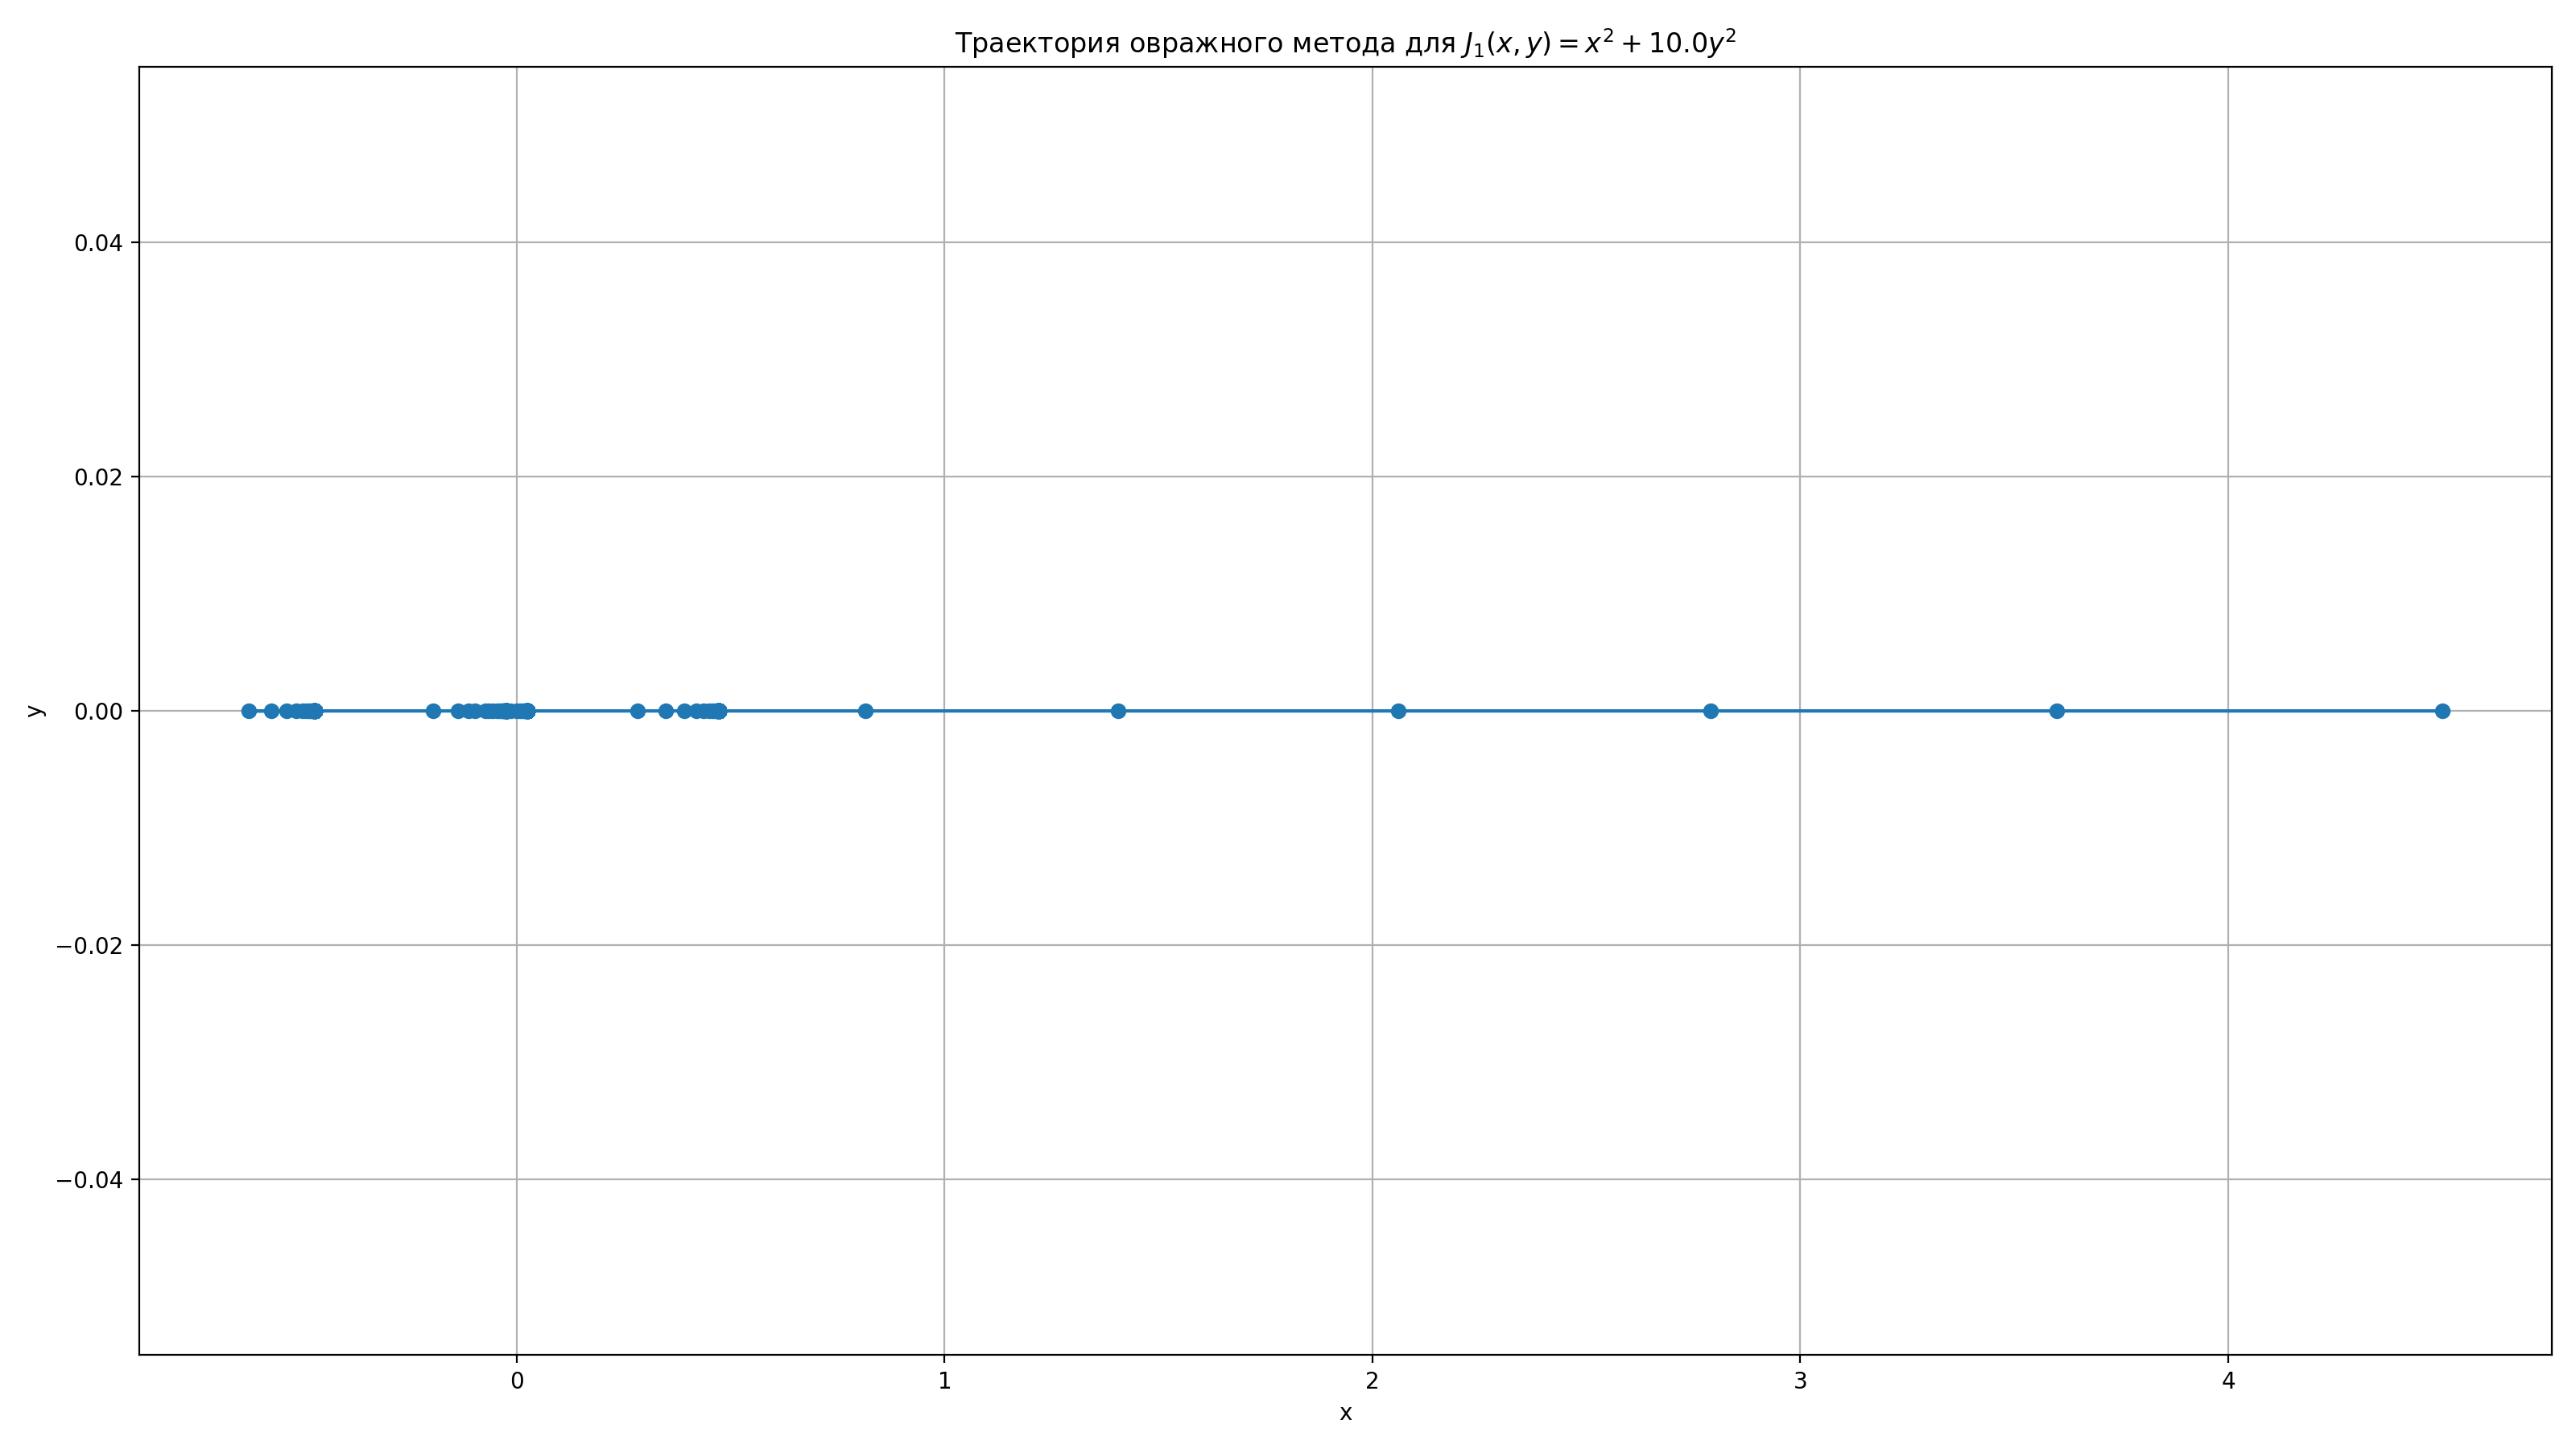

  J(x_k):


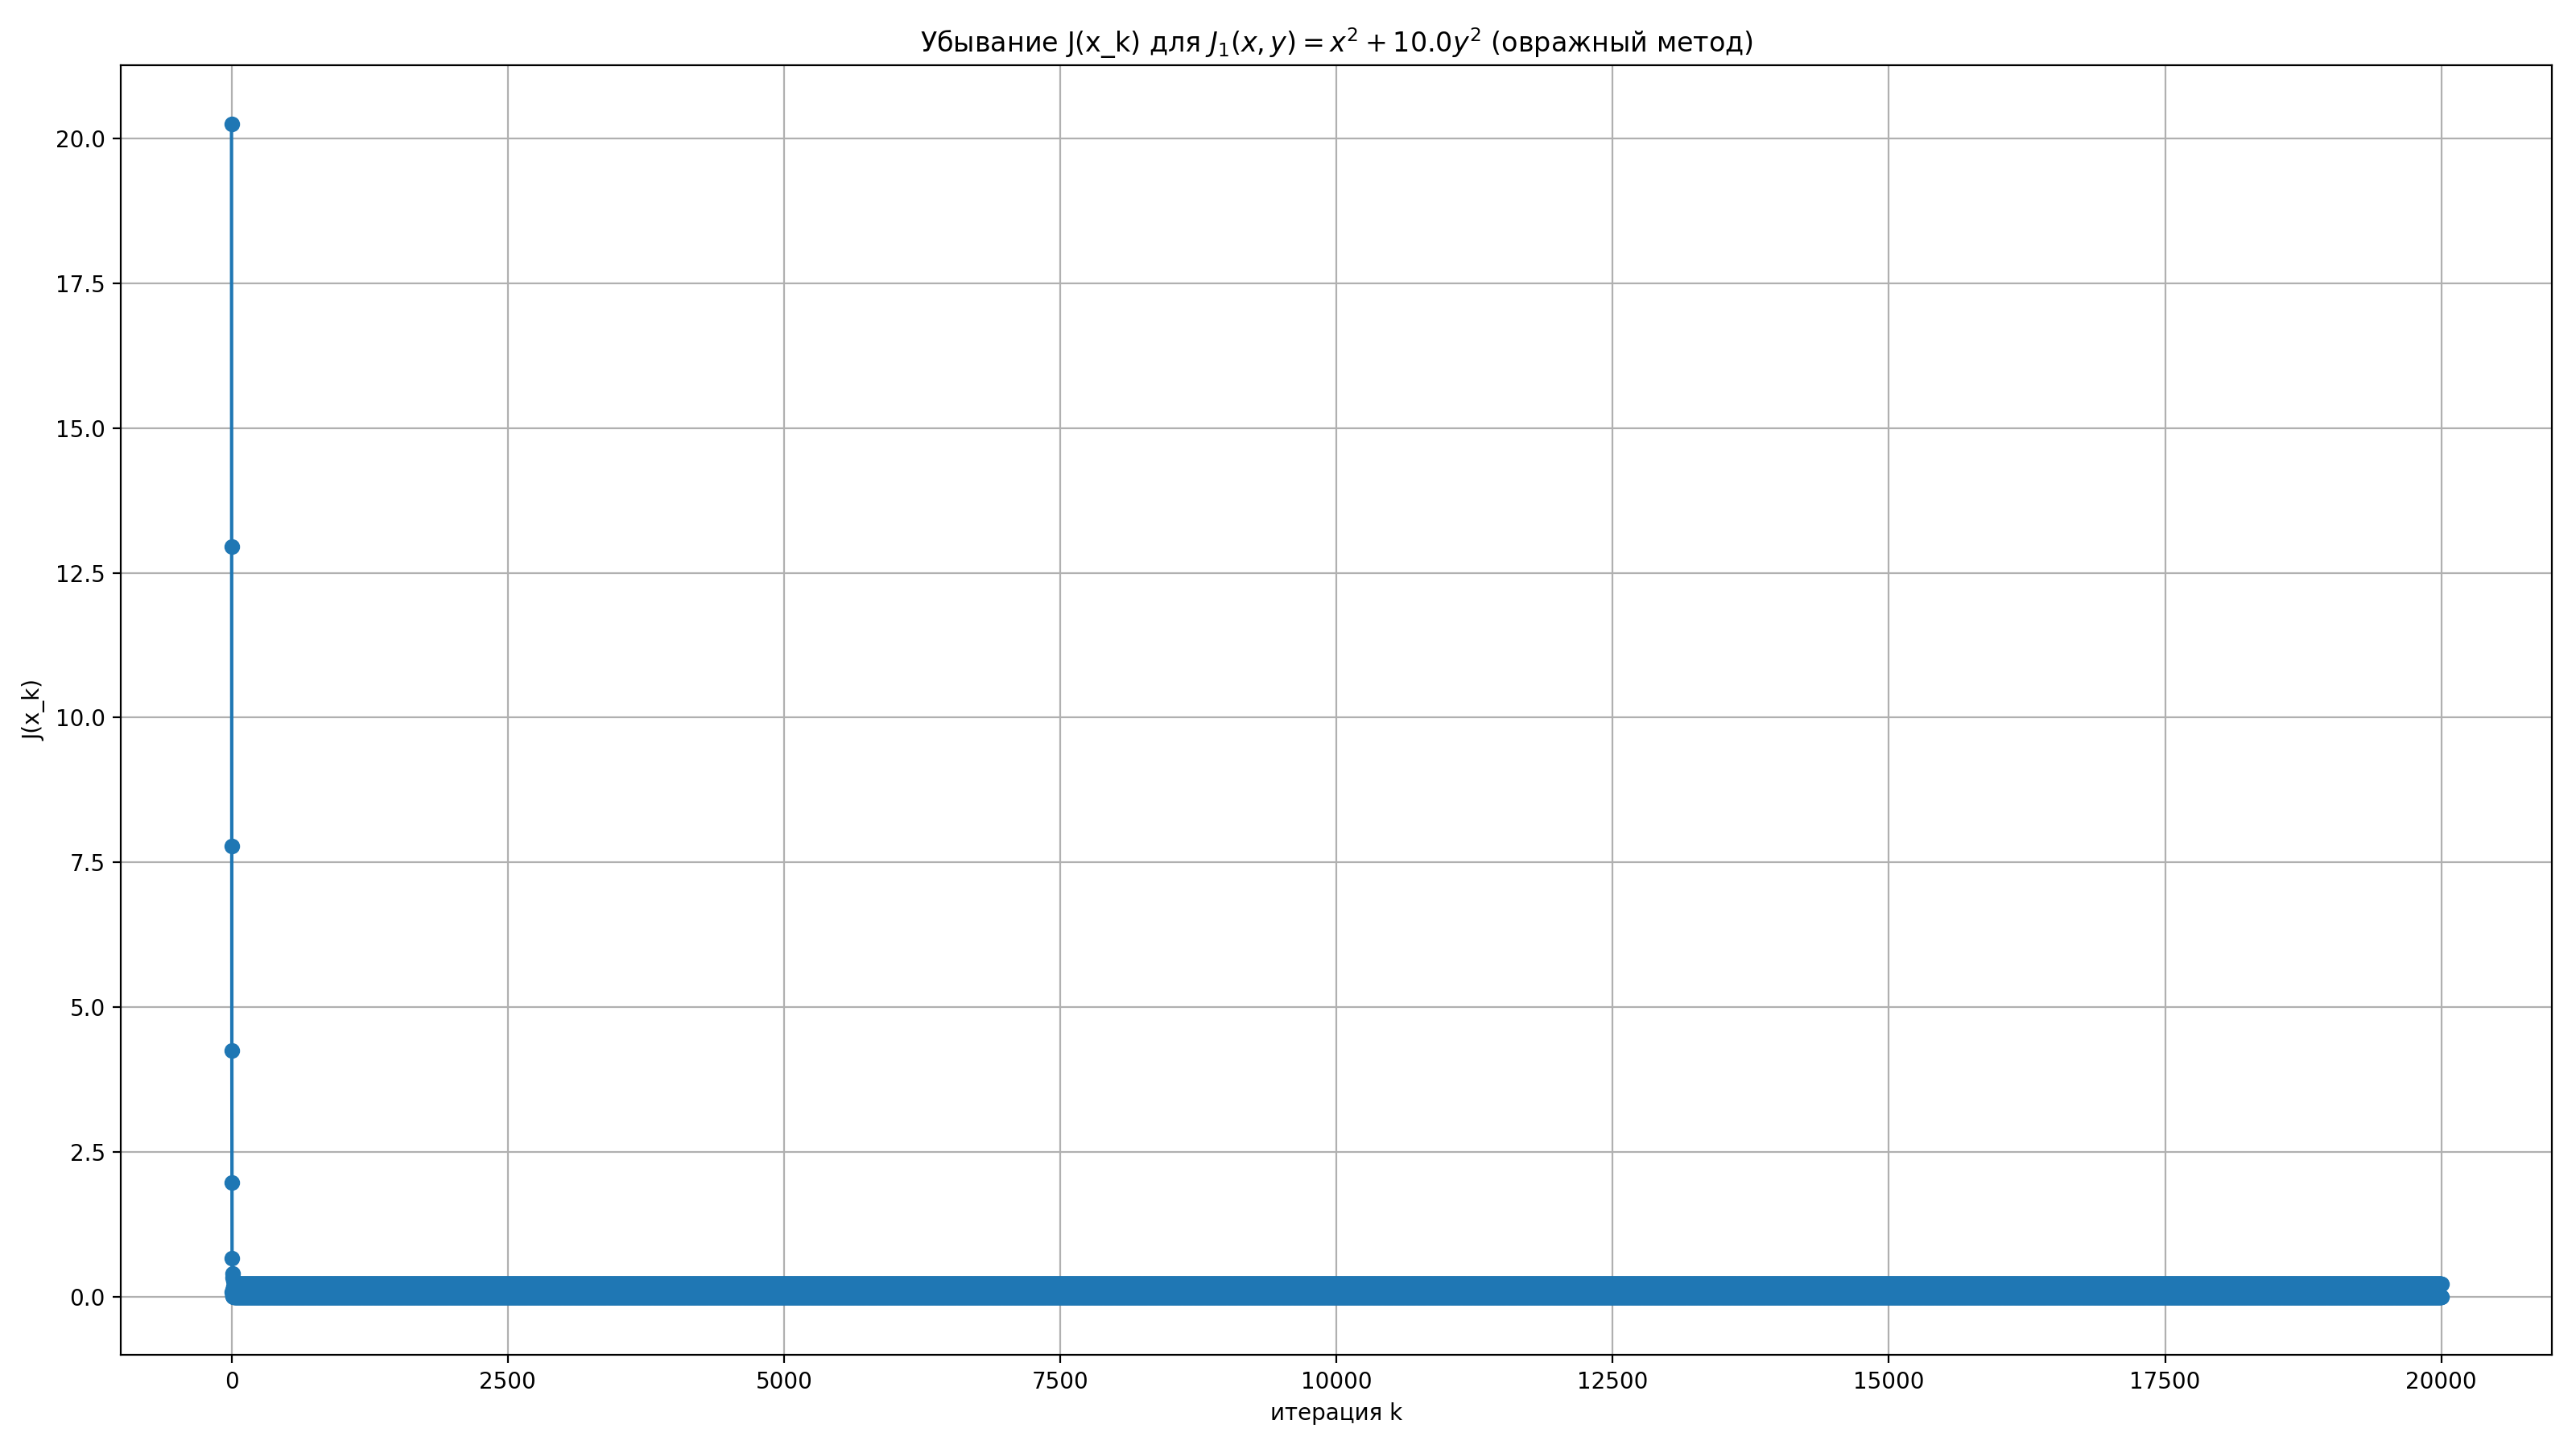

------------------------------------------------------------
Функция j2
  шаг градиентного спуска: 0.05
  овражный шаг h: 0.5
  x*  [ 4.99749749e-001 -1.97626258e-323]
  J(x*) ≈ 0.00249750
  итераций: 20001
  остановка: max_iters = 20000
  Траектория:


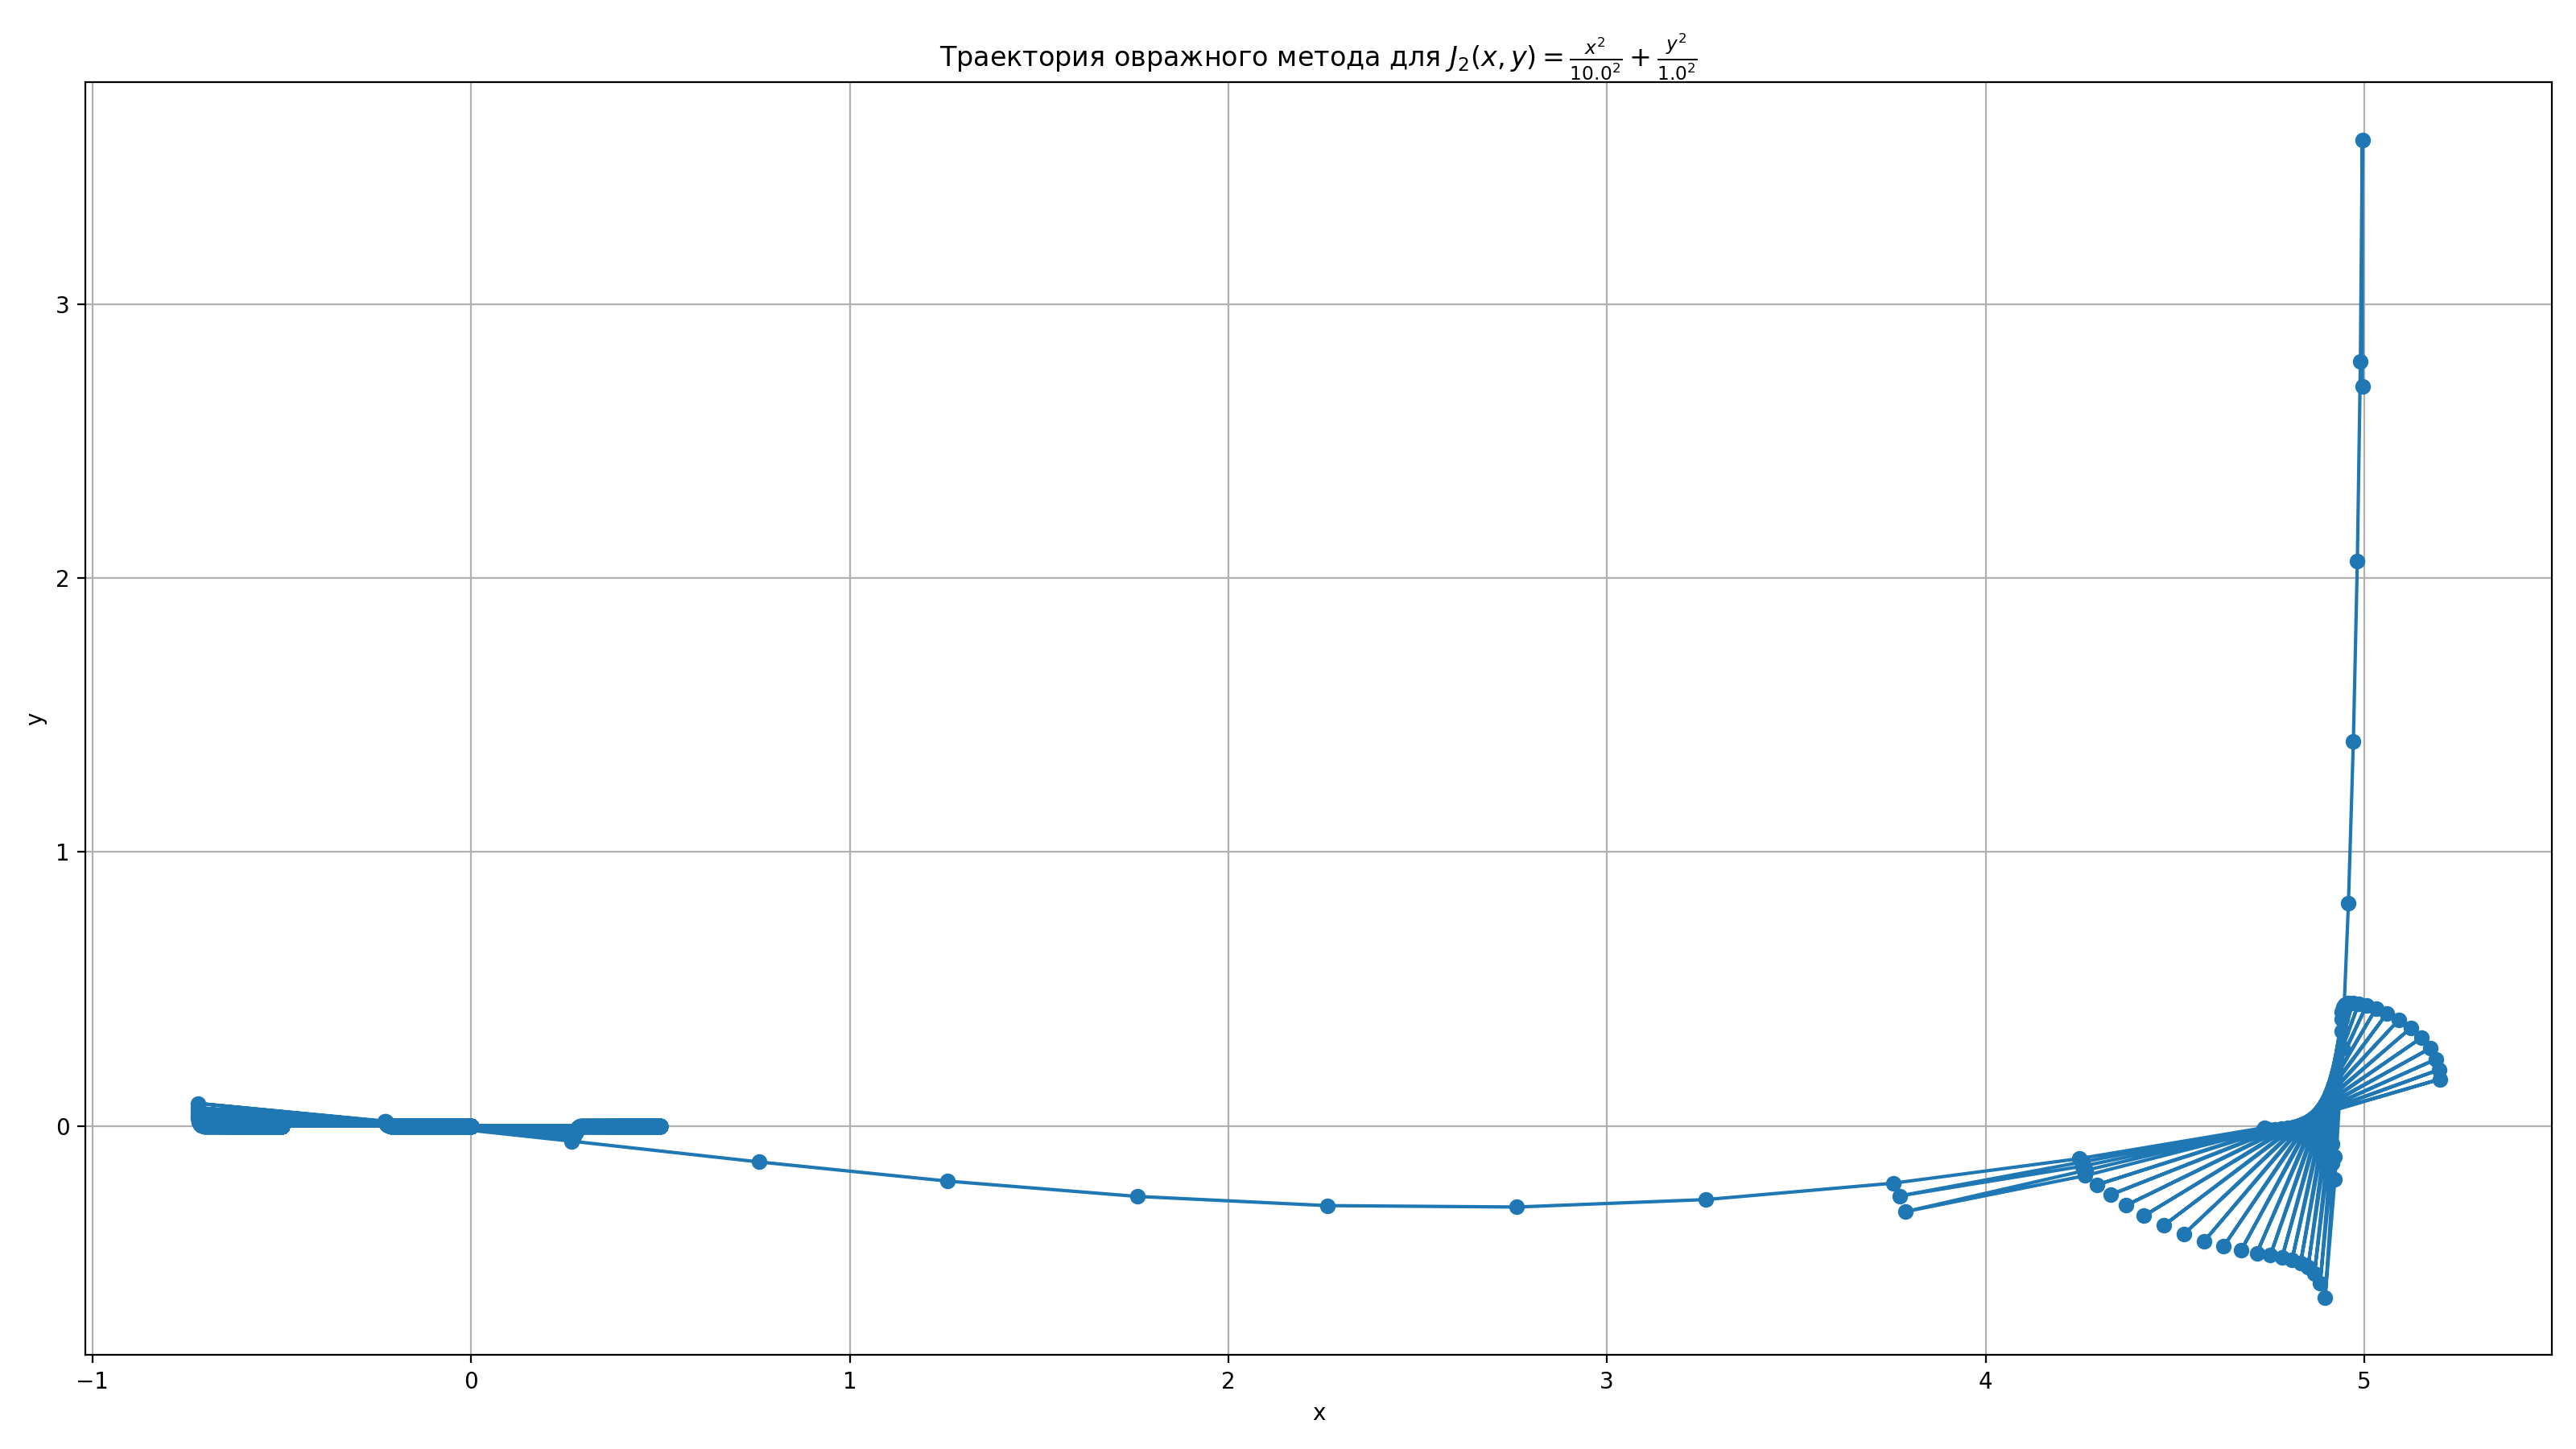

  J(x_k):


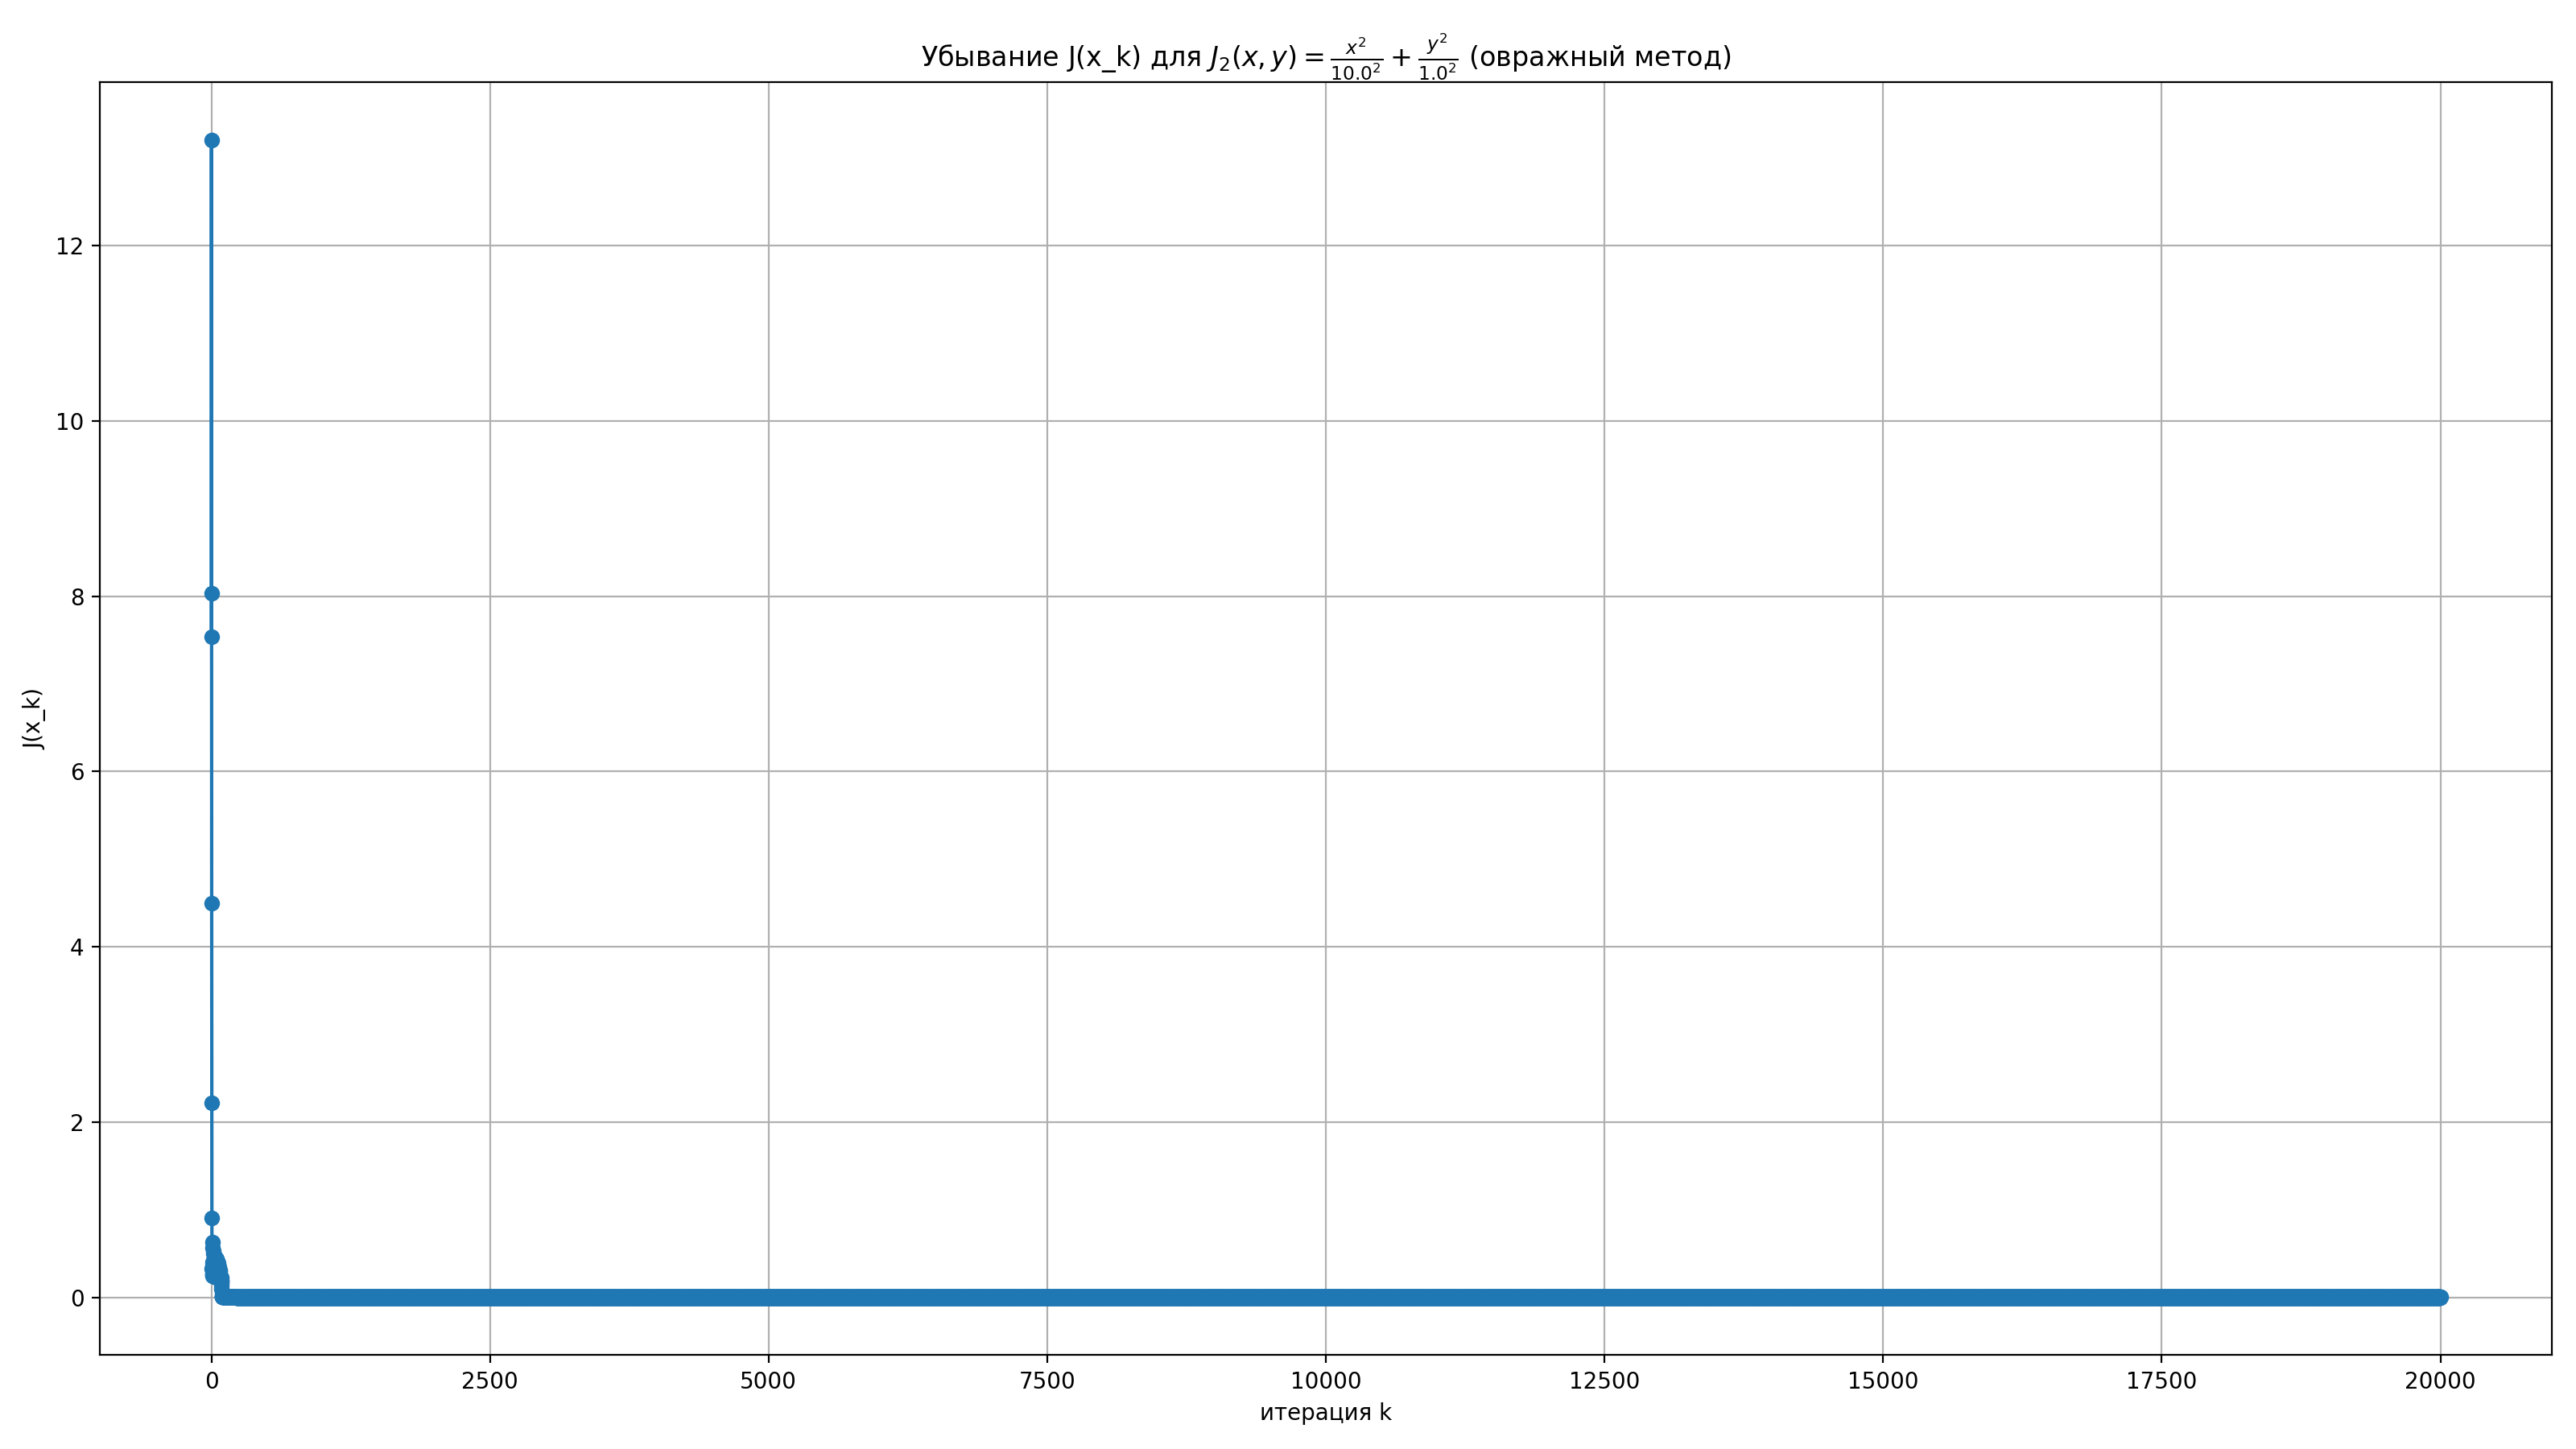

------------------------------------------------------------
Функция j3
  шаг градиентного спуска: 0.01
  овражный шаг h: 0.2
  x*  [1.13333273 1.00371743]
  J(x*) ≈ 2.24444705
  итераций: 60
  остановка: tol_f: |J_(k+1)-J_k| = 7.94e-07
  Траектория:


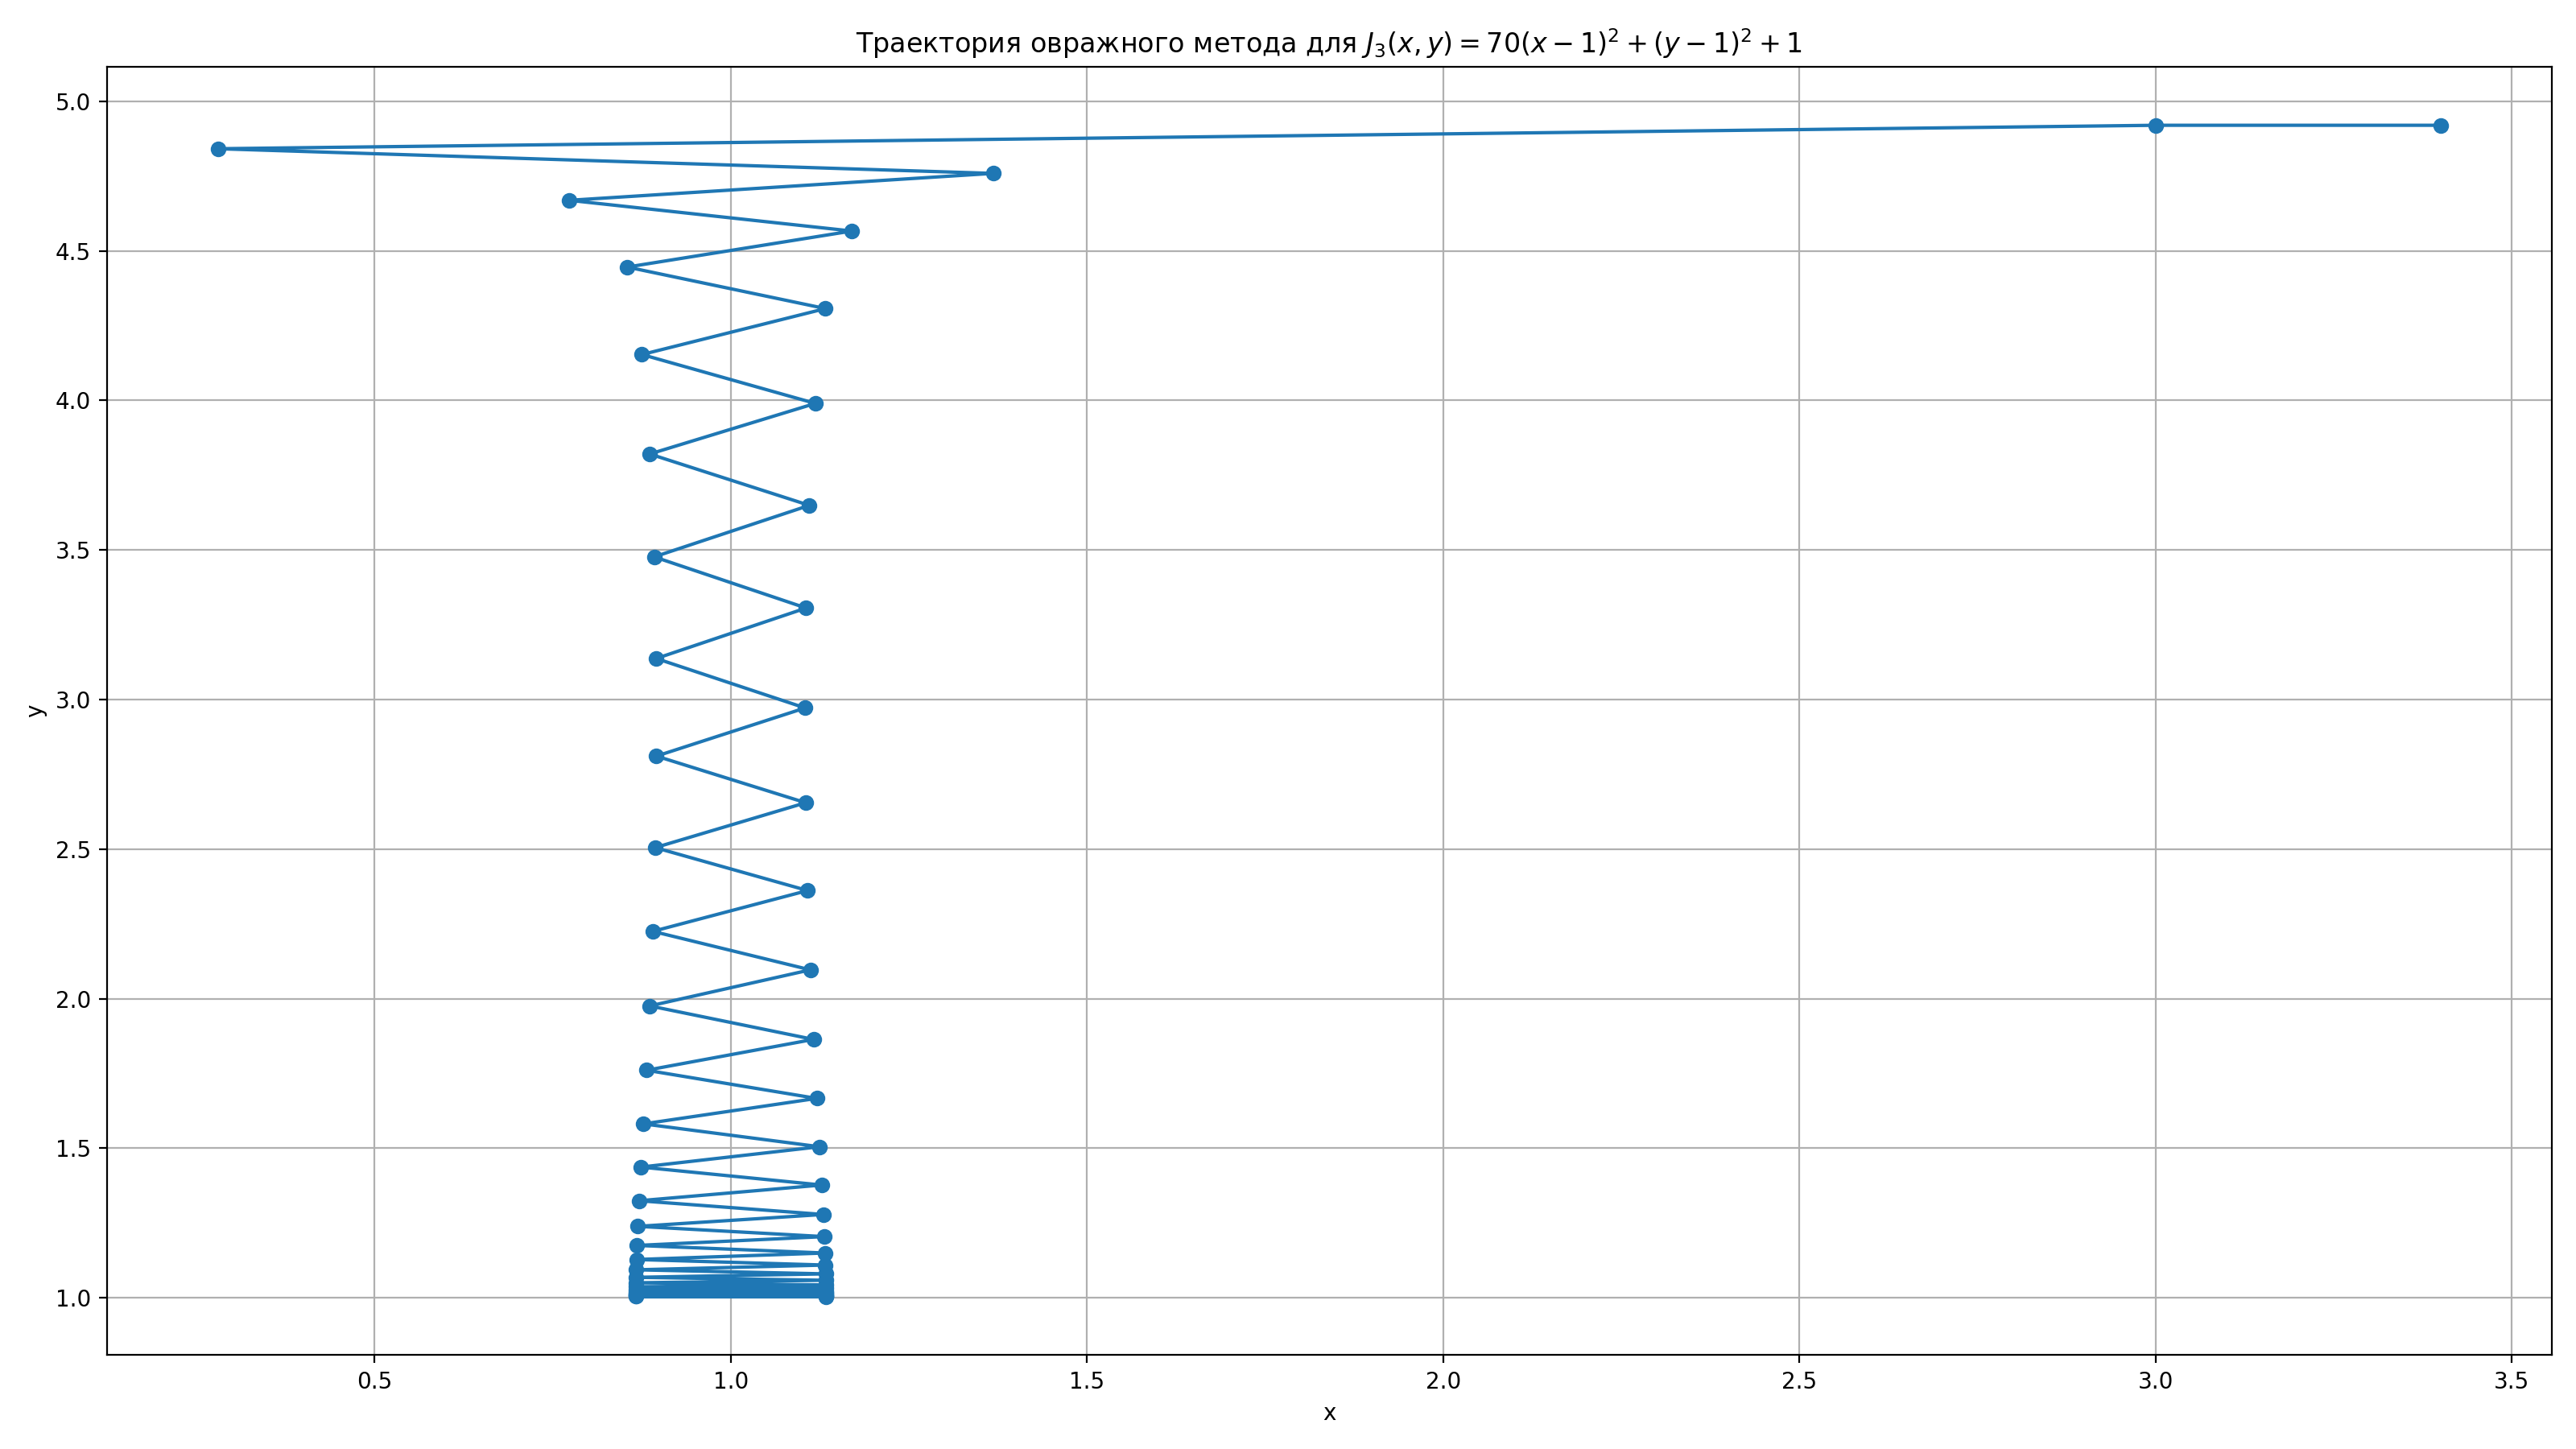

  J(x_k):


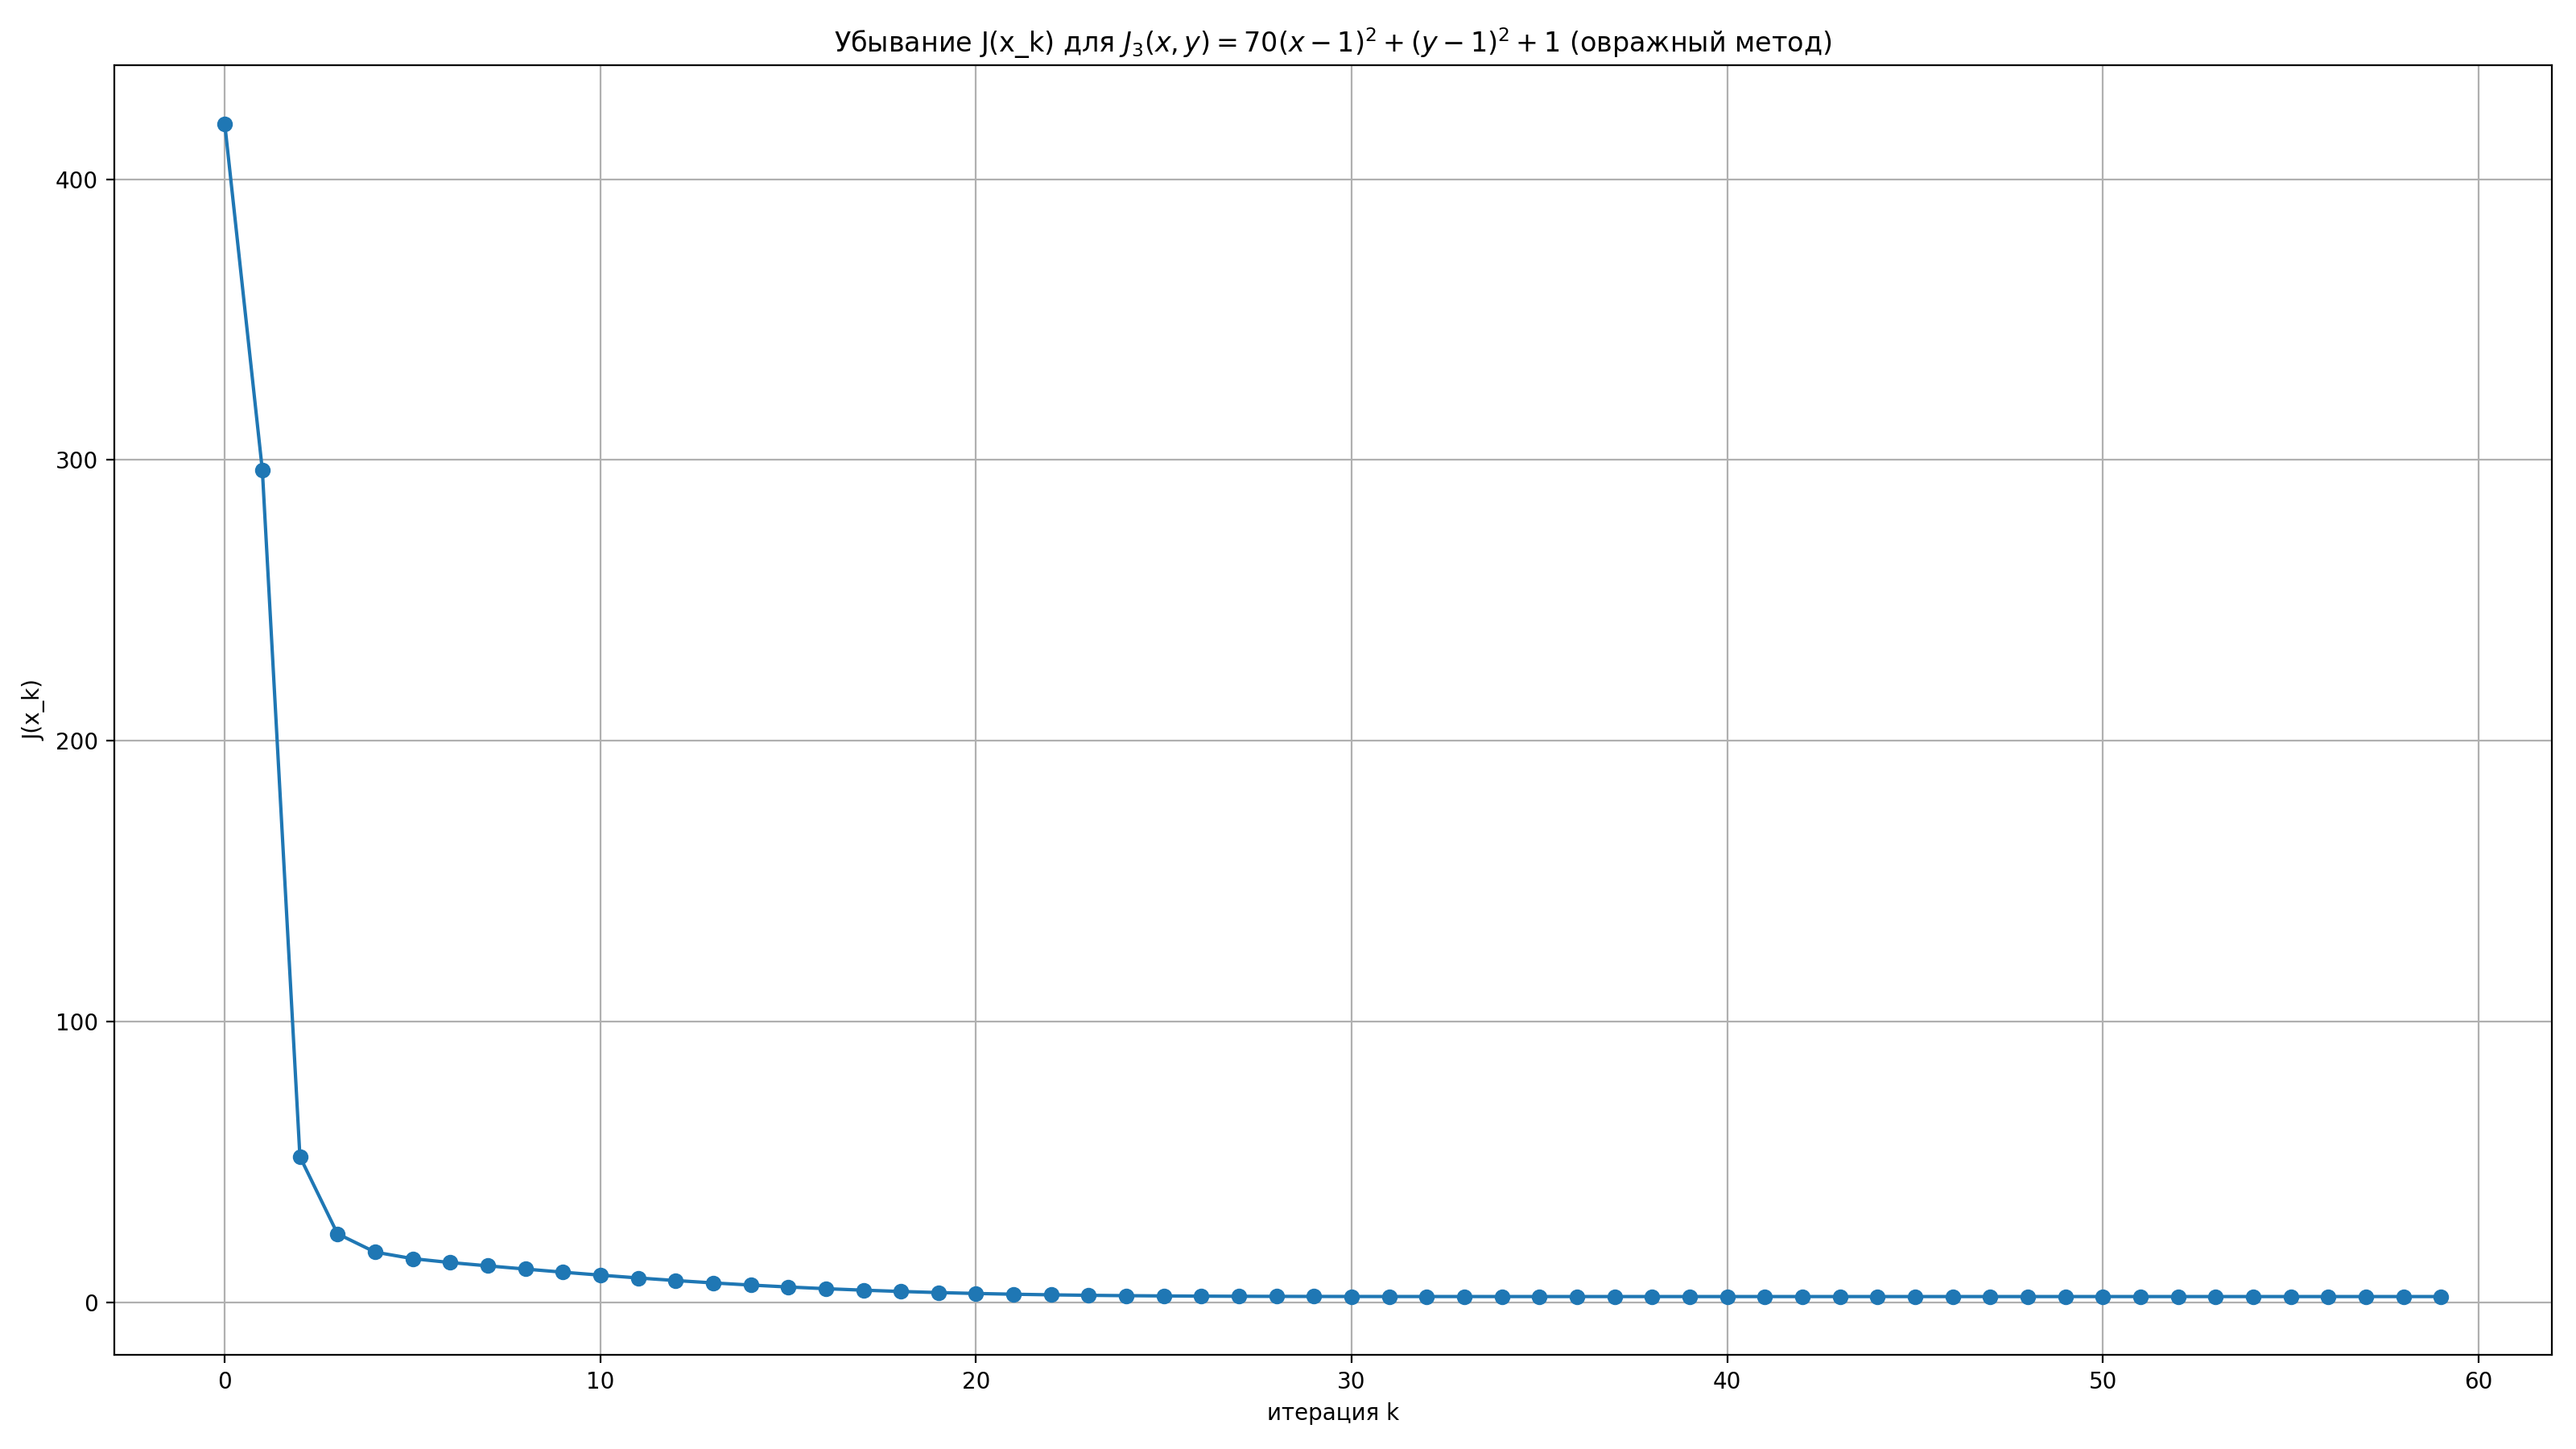

------------------------------------------------------------
Функция j4
  шаг градиентного спуска: 0.001
  овражный шаг h: 0.1
  x*  [7.90025543 0.99926417]
  J(x*) ≈ 1.01589127
  итераций: 20001
  остановка: max_iters = 20000
  Траектория:


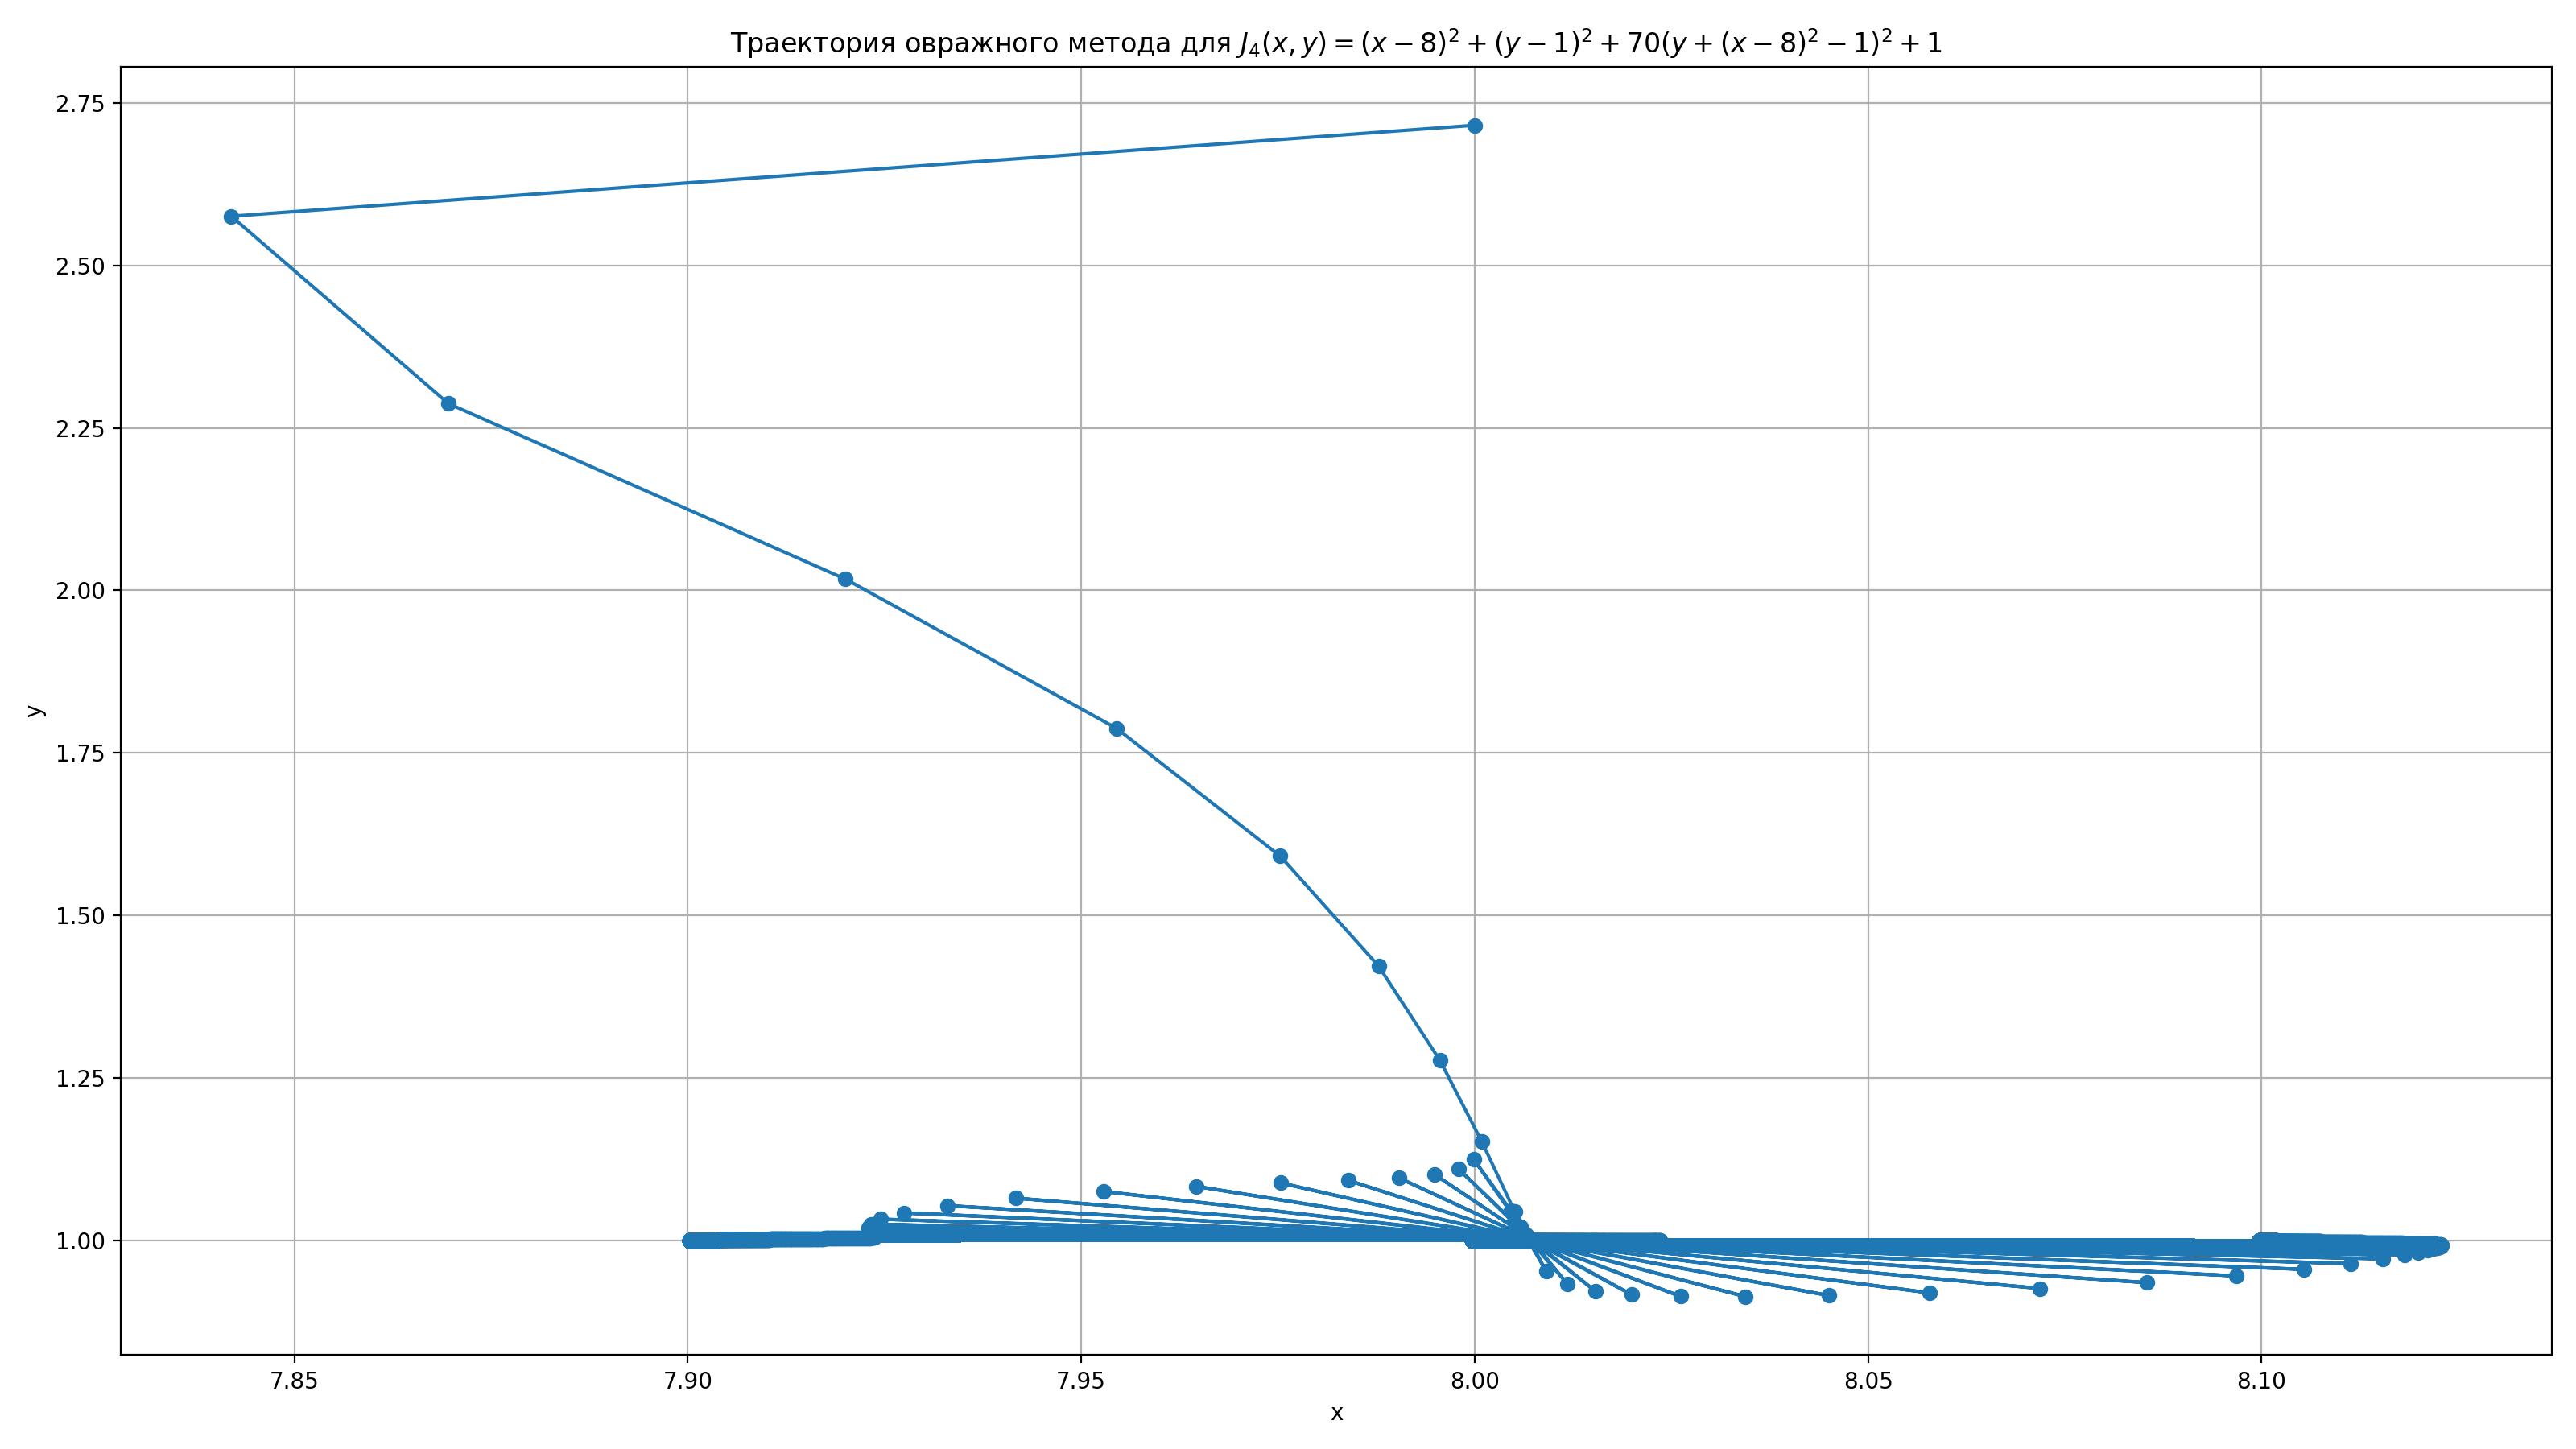

  J(x_k):


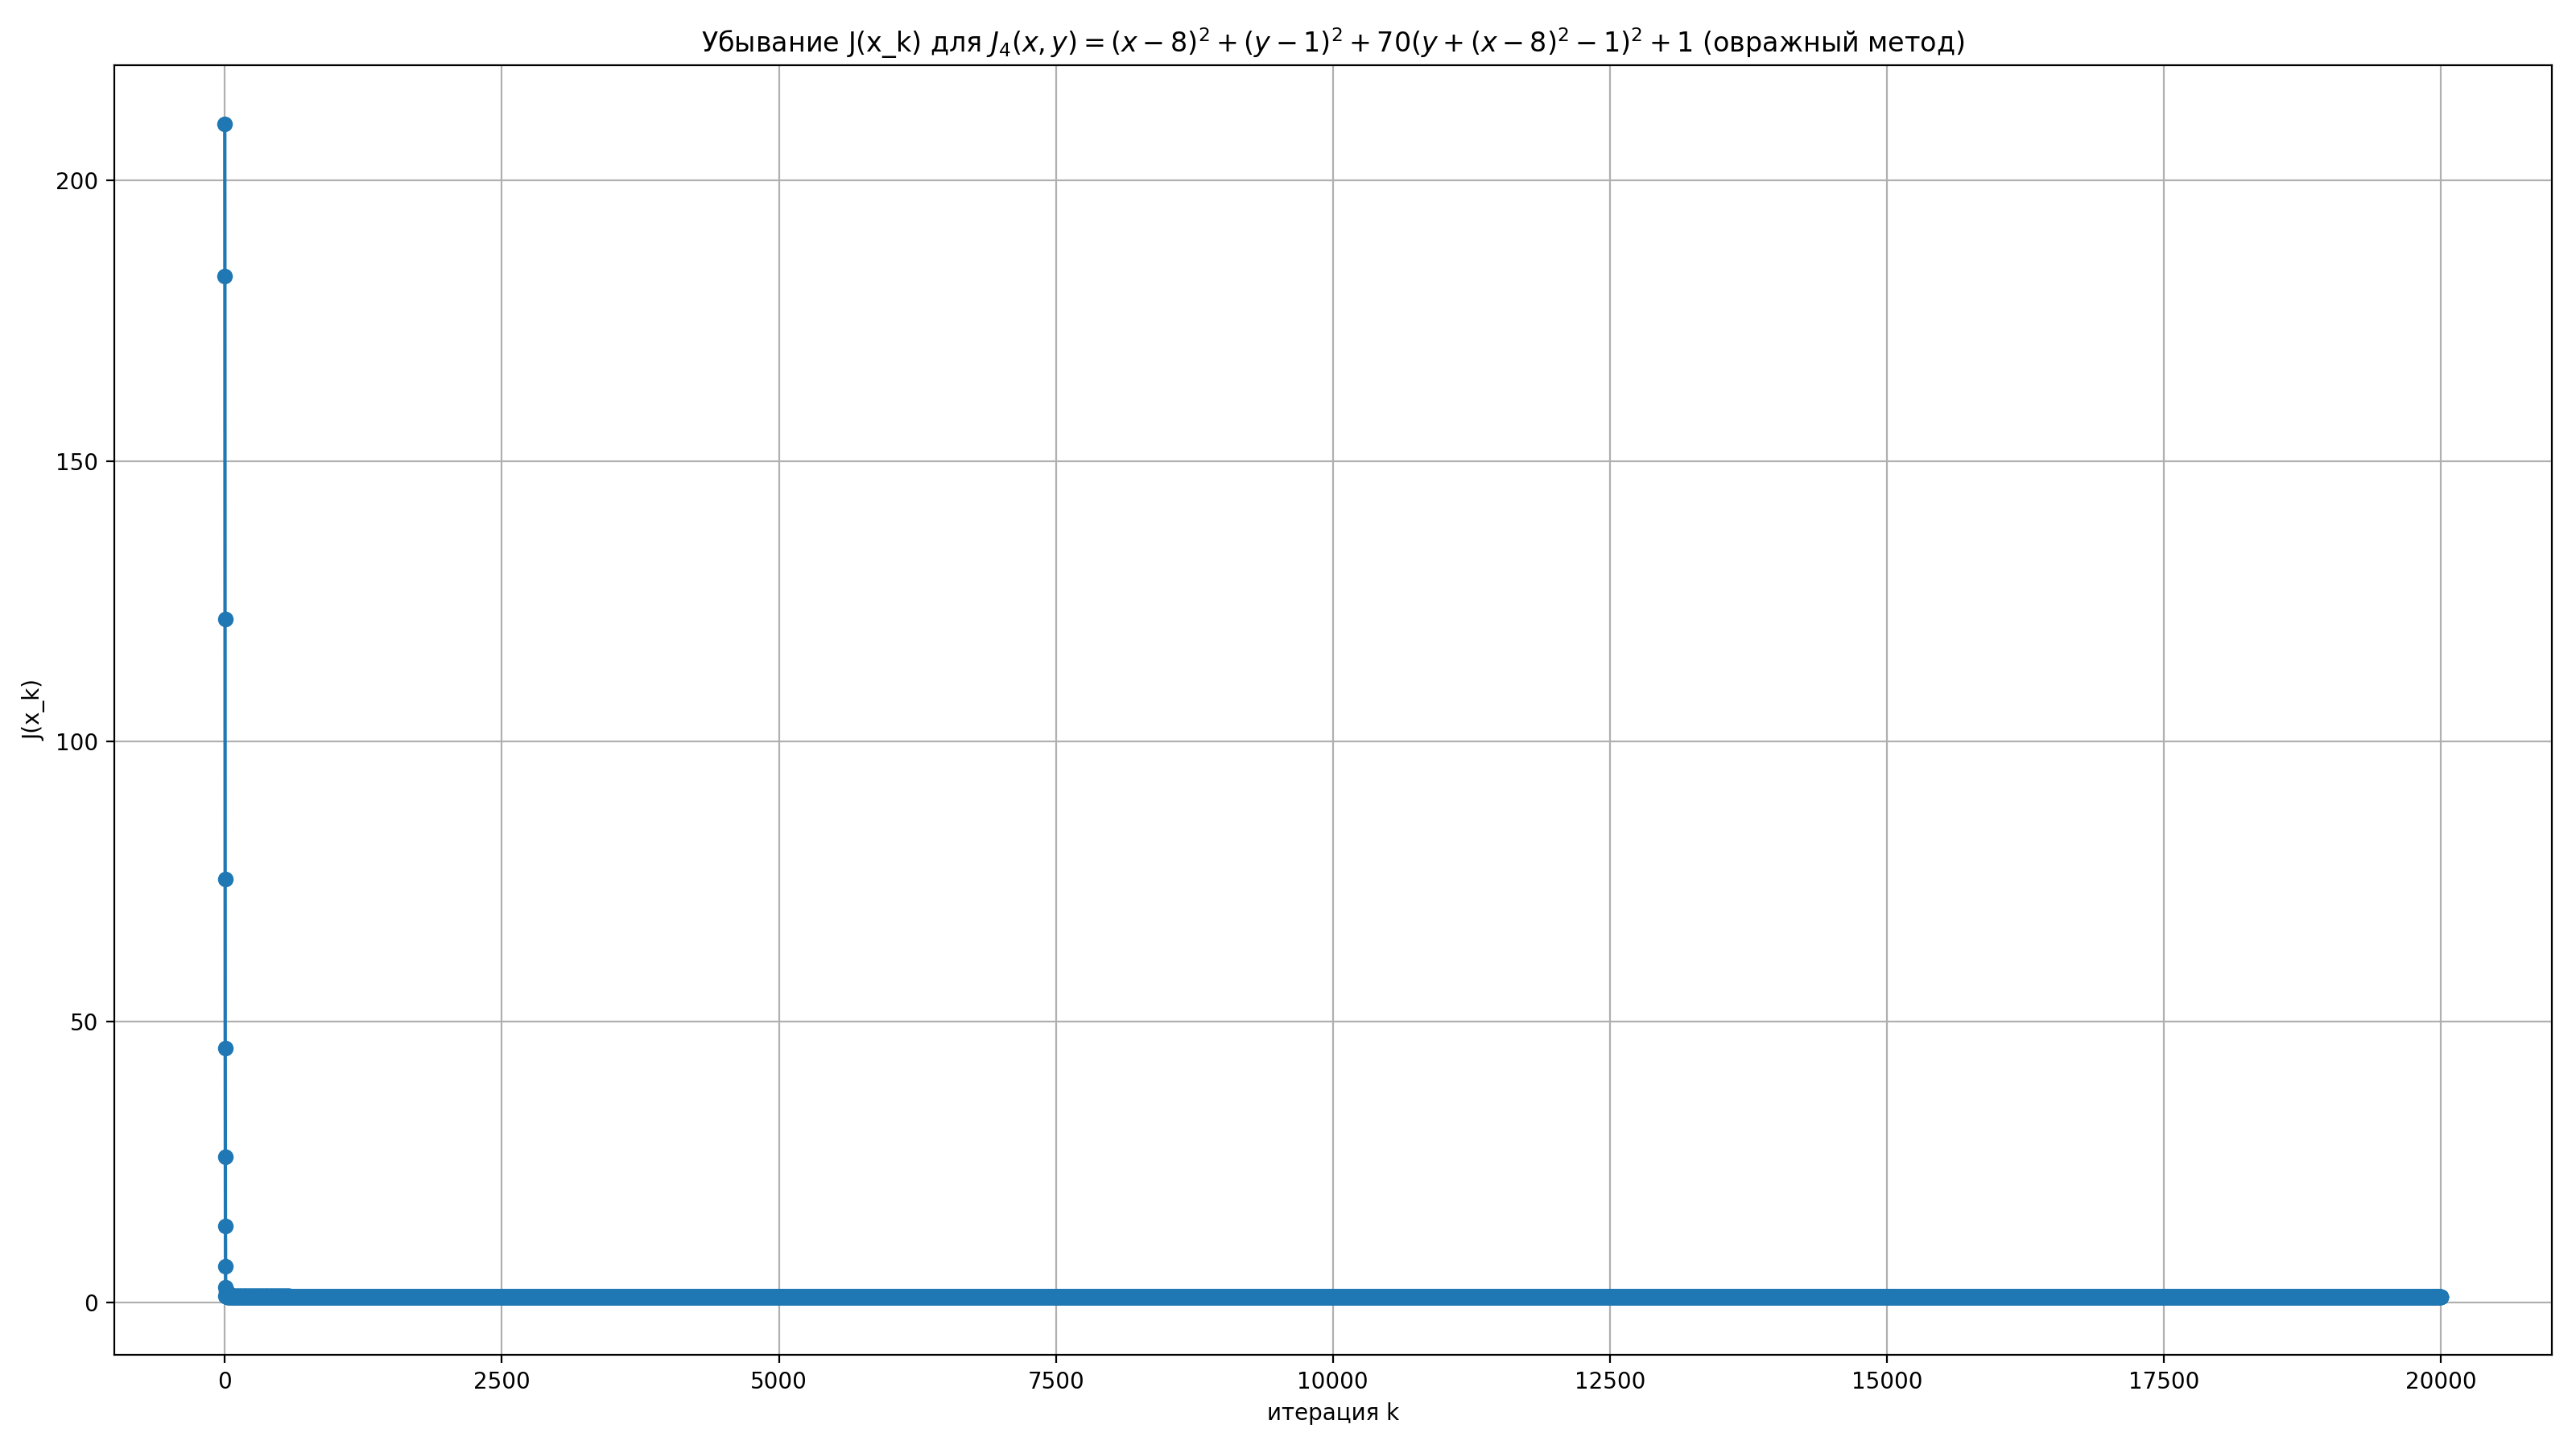

------------------------------------------------------------
Функция j5
  шаг градиентного спуска: 0.005
  овражный шаг h: 0.1
  x*  [8.05161484 1.04666096]
  J(x*) ≈ 1.68091064
  итераций: 97
  остановка: tol_f: |J_(k+1)-J_k| = 9.40e-07
  Траектория:


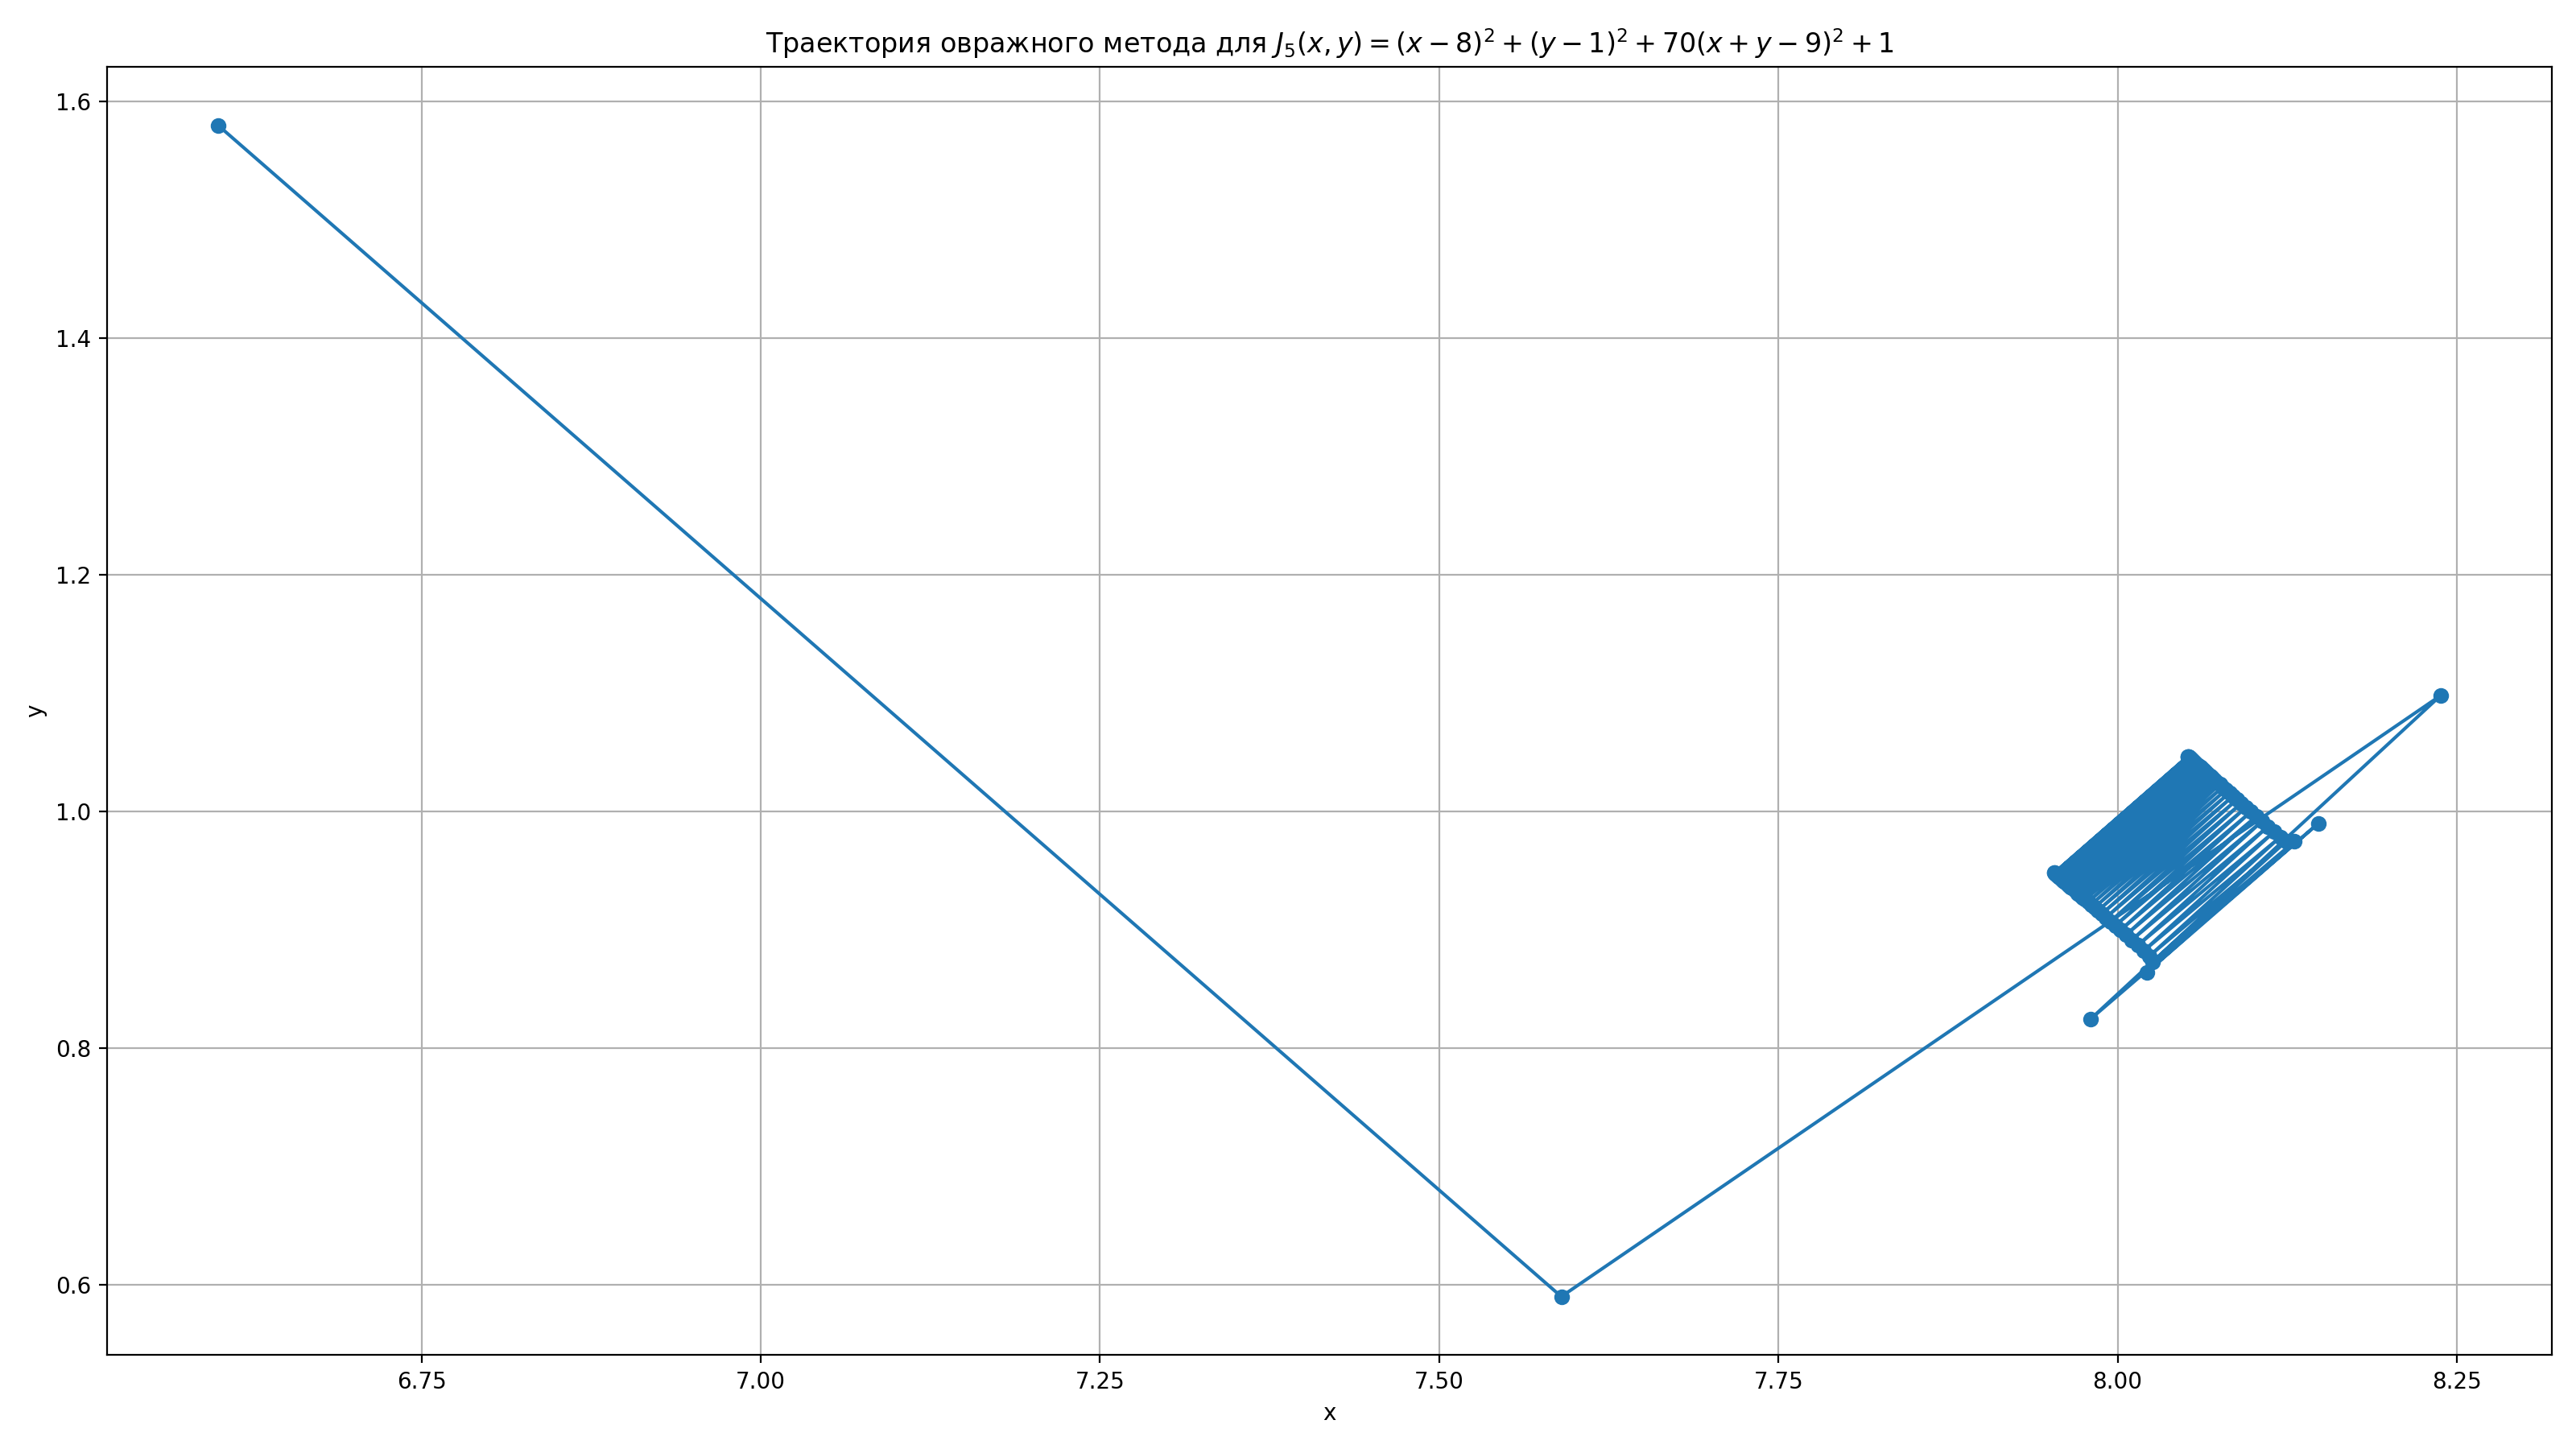

  J(x_k):


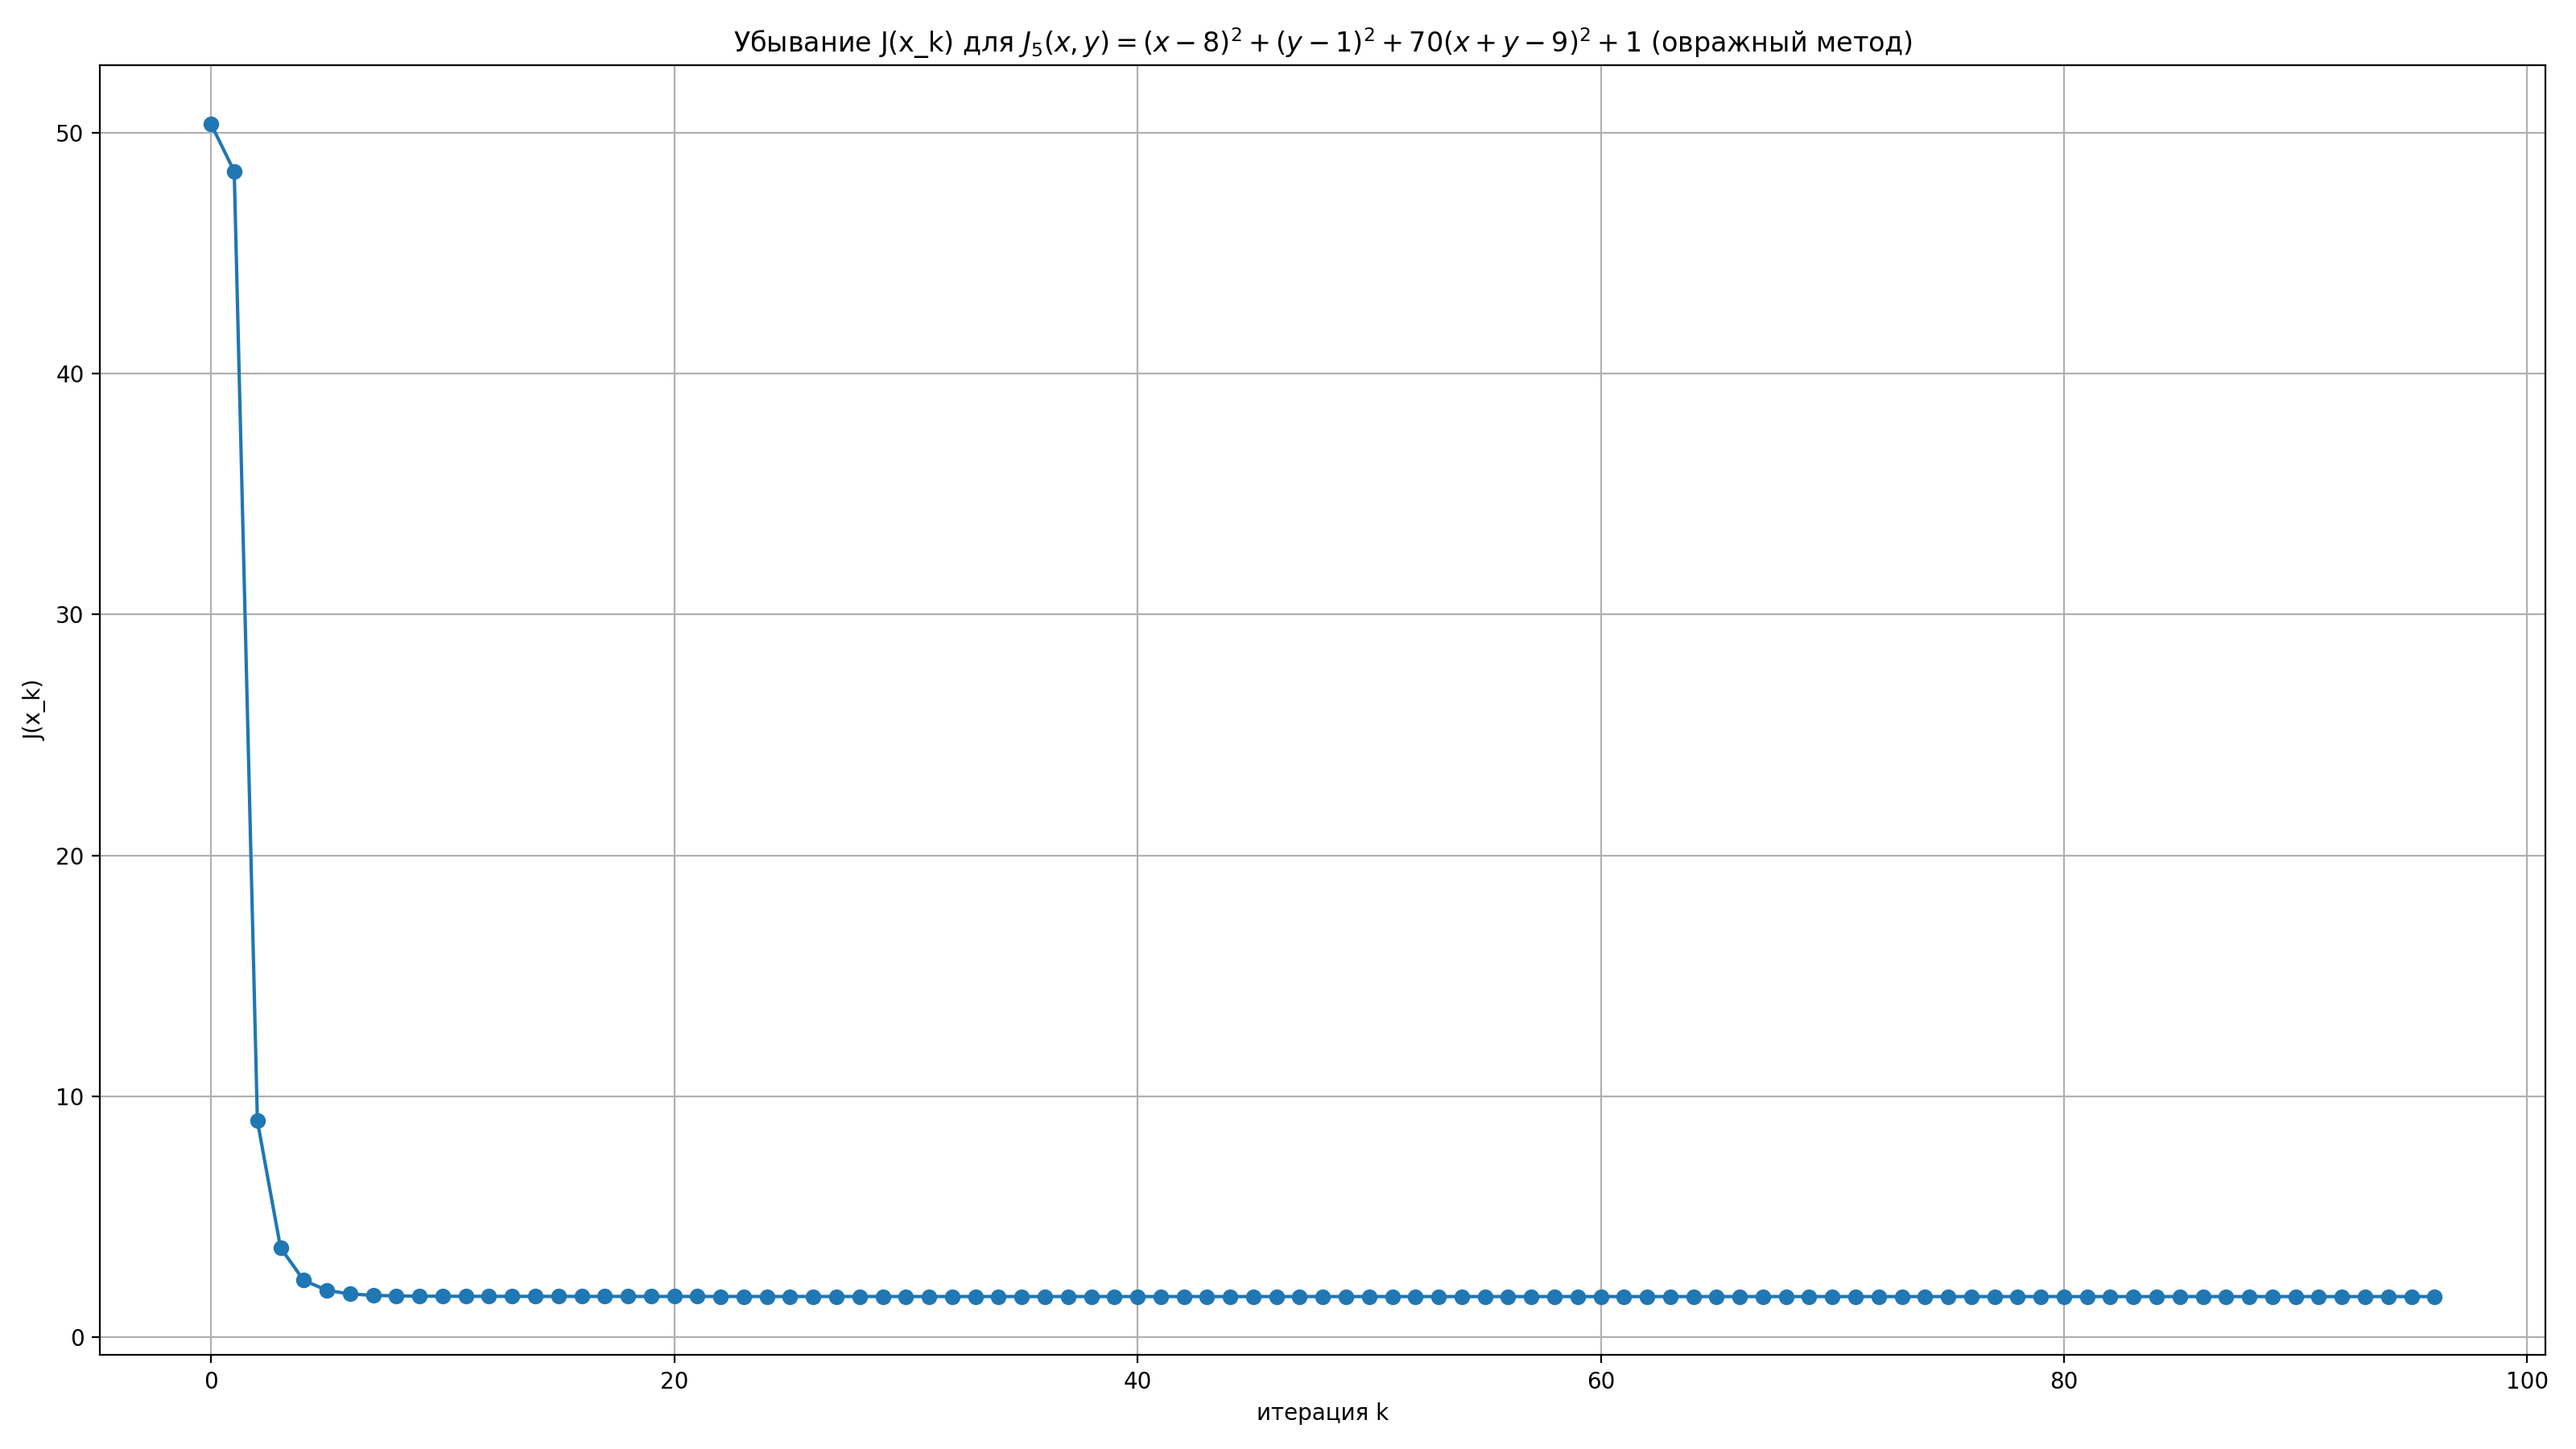

------------------------------------------------------------


In [11]:
from IPython.display import Image, display  # если ещё не импортировал

for key, info in results_ravine.items():
    print(f"Функция {key}")
    print(f"  шаг градиентного спуска: {info['step_gd']}")
    print(f"  овражный шаг h: {info['h_ravine']}")
    print(f"  x*  {info['x_star']}")
    print(f"  J(x*) ≈ {info['J_star']:.8f}")
    print(f"  итераций: {info['iters']}")
    print(f"  остановка: {info['stop_reason']}")
    print("  Траектория:")
    display(Image(filename=info["traj_file"]))
    print("  J(x_k):")
    display(Image(filename=info["J_file"]))
    print("-" * 60)

In [9]:
func_labels = {
    "j1": r"$J_1$",
    "j2": r"$J_2$",
    "j3": r"$J_3$",
    "j4": r"$J_4$",
    "j5": r"$J_5$",
}

def latex_escape_text(s: str) -> str:
    s = str(s)
    return s.replace("_", r"\_")

rows = []
for key, info in results_ravine.items():
    x_star = info["x_star"]
    row = {
        "Функция": func_labels.get(key, key),
        "Параметры шага": rf"$h_{{gd}} = {info['step_gd']}$, $h = {info['h_ravine']}$",
        "Найденная точка $x^*$": f"({x_star[0]:.6f}, {x_star[1]:.6f})",
        "$J(x^*)$": f"{info['J_star']:.8f}",
        "Критерий остановки": latex_escape_text(info["stop_reason"]),
    }
    rows.append(row)

df_ravine = pd.DataFrame(rows)
df_ravine

,Функция,Параметры шага,Найденная точка $x^*$,$J(x^*)$,Критерий остановки
0,$J_1$,"$h_{gd} = 0.05$, $h = 0.5$","(-0.472376, 0.000000)",0.22313879,max\_iters = 20000
1,$J_2$,"$h_{gd} = 0.05$, $h = 0.5$","(0.499750, -0.000000)",0.00249750,max\_iters = 20000
2,$J_3$,"$h_{gd} = 0.01$, $h = 0.2$","(1.133333, 1.003717)",2.24444705,tol\_f: |J\_(k+1)-J\_k| = 7.94e-07
3,$J_4$,"$h_{gd} = 0.001$, $h = 0.1$","(7.900255, 0.999264)",1.01589127,max\_iters = 20000
4,$J_5$,"$h_{gd} = 0.005$, $h = 0.1$","(8.051615, 1.046661)",1.68091064,tol\_f: |J\_(k+1)-J\_k| = 9.40e-07


In [12]:
df_ravine.to_csv("ravine_results.csv", index=False)
print("CSV сохранён в ravine_results.csv")

latex_body = df_ravine.to_latex(
    index=False,
    escape=False,
    column_format="|c|c|c|c|c|",
)

table_tex = r"""\begin{table}[H]
    \centering
    \resizebox{\textwidth}{!}{%
""" + latex_body + r"""
    }
    \caption{Итоговые точки минимума и значения функционала для овражного метода.}
    \label{tab:ravine_results}
\end{table}
"""

with open("ravine_results_table.tex", "w", encoding="utf-8") as f:
    f.write(table_tex)

print("LaTeX-таблица сохранена в ravine_results_table.tex")

CSV сохранён в ravine_results.csv
LaTeX-таблица сохранена в ravine_results_table.tex
